### Workflow

Figma diagram: https://www.figma.com/file/PFKdJO3HTIcM9g4nmVONCT/HRA-Data-Explorer?type=whiteboard&node-id=1%3A108&t=XGoN91s7IKbyZ7xk-1

Below is the information about the diagram:

1. Dataset Collections:
The process begins with RUI Registered Tissue datasets (553), a collection of tissue datasets registered in a specific repository or database.
These datasets are linked to specific Organs and Anatomical Structures.

2. Dataset Processing:
The datasets are processed to produce Anatomical Structures/Cell type information of 2D FTUs. - 193
There is a decision point or a step to possibly sort these structures, which leads to the extraction of a Cell Summary, including cell type biomarker gene expression data that maps to the FTU specific cell types.
    
    1. Compare FTU's cell type information between Azimuth, PopV and Celltypist. (Azimuth > celltypist > popv)
    2. Get the list of dataset for FTU.
        1. Cell summary from the atlas-as-cell-summaries.jsonld
        2. Add organ data from the cell annotation crosswalk files
    3. Any dataset that is been shared among two FTUs
        1. Remove 

3. Cell Type Mapping:
list of 2D FTUs are used to map Cell Types, leading to a set of inquiries on how to best extract data from the datasets used in Step 1 and 2

4. Vasculature Mapping

5. cell type info:
   1. Exclusively within FTU:
      | FTU                       | Cell Types                                                                                      |
        |---------------------------|--------------------------------------------------------------------------------------------------|
        | Cortical Collecting Duct  | Kidney collecting duct beta-intercalated cell, Kidney collecting duct alpha-intercalated cell, Kidney cortex collecting duct principal cell |
        | Outer Medullary Collecting Duct | Kidney outer medulla collecting duct intercalated cell, Kidney outer medulla collecting duct principal cell |
        | Inner Medullary Collecting Duct | Kidney inner medulla collecting duct principal cell                                          |
        | Thick Ascending Limb      | Kidney loop of Henle thick ascending limb epithelial cell                                        |
        | Descending Thin Limb      | Kidney loop of Henle thin descending limb epithelial cell                                        |
        | Ascending Thin Limb       | Kidney loop of Henle thin ascending limb epithelial cell                                         |
        | Nephron                   | Cortical collecting duct, Proximal straight tubule, Proximal convoluted tubule segment 2, Proximal convoluted tubule segment 1, Epithelial cell of proximal tubule segment 1, Distal convoluted tubule, Kidney distal convoluted tubule epithelial cell, Renal connecting tubule, Kidney connecting tubule epithelial cell, Macula densa epithelial cell, Thick ascending limb of loop of Henle, Loop of Henle ascending limb thin segment, Descending thin limb, Kidney inner medulla collecting duct, Renal Corpuscle, Kidney loop of Henle thin ascending limb epithelial cell, Kidney loop of Henle thin descending limb epithelial cell, Kidney loop of Henle thick ascending limb epithelial cell, Kidney cortex collecting duct principal cell, Kidney outer medulla collecting duct principal cell |
        | Renal Corpuscle           | Glomerular mesangial cell, Glomerular visceral epithelial cell, Epithelial cell of proximal tubule, Glomerular capillary endothelial cell, Efferent arteriole endothelial cell, Parietal epithelial cell, Afferent arteriole endothelial cell, Macula densa epithelial cell |
        | Crypt Of Lieberkuhn       | Large intestine crypt goblet cell, Enterocyte of epithelium of large intestine, Neuroendocrine cell, Intestinal crypt stem cell of large intestine, Intestinal tuft cell |
        | Liver Lobule              | Hepatic oval stem cell, Endothelial cell of hepatic sinusoid, Hepatic stellate cell, Kupffer Cell, Hepatocyte |
        | Bronchial Submucosal Gland | Airway submucosal gland duct ciliated cell, Airway submucosal gland duct basal cell, Mucus secreting cell of bronchus submucosal gland, Airway submucosal gland collecting duct epithelial cell, Serous secreting cell of bronchus submucosal gland, Myoepithelial cell of bronchus submucosal gland |
        | Pulmonary Alveolus        | Type II pneumocyte, Type I pneumocyte, Alveolar type 1 fibroblast cell, Secondary crest myofibroblast |
        | Intercalated Duct         | Epithelial cell of exocrine pancreas, Pancreatic centro-acinar cell, Intercalated duct of pancreas |
        | Acinus                    | Pancreatic acinar cell, Pancreatic goblet cell, Epithelial cell of exocrine pancreas, Pancreatic centro-acinar cell, Intercalated duct of pancreas |
        | Islet of Langerhans       | Pancreatic A cell, Type B pancreatic cell, Pancreatic D cell, Pancreatic PP cell |
        | Prostate Glandular Acinus | Luminal cell of prostate epithelium, Basal cell of prostate epithelium |
        | Dermal Papilla            | Skin fibroblast |
        | Epidermal Ridge           | Prickle cell, Epidermal Langerhans cell, Basal cell of epidermis, Merkel cell, Melanocyte of skin |
        | Villus                    | Tuft cell of small intestine, Enterocyte, Duodenal goblet cell |
        | Red Pulp                  | CD14-positive, CD16-low monocyte, Follicular dendritic cell, Plasmablast, Neutrophil, Splenic tingible body macrophage, Splenic marginal zone macrophage, Splenic red pulp macrophage, Dendritic cell, human, Hematopoietic stem cell, Reticular cell of splenic sinusoid |
        | White Pulp                | Splenic white pulp macrophage, Smooth muscle cell, Splenic endothelial cell, Stromal cell, Reticular cell of splenic cord, CD14-positive, CD16-low monocyte, Follicular dendritic cell, Plasmablast, Neutrophil |
        | Thymus Lobule             | Double-positive, alpha-beta thymocyte, Thymus subcapsular epithelium, Thymic plasmacytoid dendritic cell, Thymic cortical macrophage, Subcapsular cortical epithelial cell, Beige adipocyte, Medullary thymic epithelial cell type 1, Hassall's corpuscle, Corticomedullary thymic epithelial cell, Thymic medullary macrophage |

   2. Shared between FTUs
   
      | Cell Type                               | FTU 1                          | FTU 2                          |
      |-----------------------------------------|--------------------------------|--------------------------------|
        | Peritubular capillary endothelial cell  | Cortical Collecting Duct       | Outer Medullary Collecting Duct |
        | Peritubular capillary endothelial cell  | Inner Medullary Collecting Duct | Thick Ascending Limb           |
        | Macula densa epithelial cell            | Nephron                        | Renal Corpuscle                |
        | Epithelial cell of exocrine pancreas    | Intercalated Duct              | Acinus                         |
        | Pancreatic centro-acinar cell           | Intercalated Duct              | Acinus                         |
        | Intercalated duct of pancreas           | Intercalated Duct              | Acinus                         |
        | CD14-positive, CD16-low monocyte        | Red Pulp                       | White Pulp                     |
        | Follicular dendritic cell               | Red Pulp                       | White Pulp                     |
        | Plasmablast                             | Red Pulp                       | White Pulp                     |
        | Neutrophil                              | Red Pulp                       | White Pulp                     |

   

   3. Shared between FTU and surrounding tissues:
      | FTU                       | Cell Types                                                                                     |
        |---------------------------|-------------------------------------------------------------------------------------------------------|
        | Cortical Collecting Duct  | Peritubular capillary endothelial cell                                                                |
        | Outer Medullary Collecting Duct | Peritubular capillary endothelial cell                                                          |
        | Inner Medullary Collecting Duct | Peritubular capillary endothelial cell                                                          |
        | Thick Ascending Limb      | Peritubular capillary endothelial cell                                                                |
        | Descending Thin Limb      | Vasa recta descending limb cell                                                                       |
        | Ascending Thin Limb       | Vasa recta ascending limb cell                                                                        |
        | Liver Lobule              | Hepatic portal fibroblast, Blood vessel smooth muscle cell, Endothelial cell of artery, Stratified cuboidal epithelial cell, Columnar/cuboidal epithelial cell, Vein endothelial cell |
        | Pulmonary Alveolus        | Lung pericyte, Alveolar capillary type 1 endothelial cell                                             |
        | Islet of Langerhans       | Capillary endothelial cell, Macrophage                                                                |
        | Prostate Glandular Acinus | Fibroblast of subepithelial connective tissue of prostatic gland, Smooth muscle cell of prostate, Fibroblast of connective tissue of prostate, Prostate gland microvascular endothelial cell, Vascular associated smooth muscle cell, Pericyte |
        | Dermal Papilla            | Endothelial cell                                                                                      |
        | Villus                    | Natural killer cell, Fibroblast, Mast cell, Myofibroblast, Plasma cell, Dendritic cell, B cell, Eosinophil, Innate lymphoid cell, Endocrine cell, Neutrophil |
        
        
Source section:  JSON LD file:

1. JSON LD file will have information about the AS volume, cell annotation tool information, demographics and sex infromation 

In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go

### Load Reference files

In [2]:
# Local paths to save the downloaded files
popv_local_path = 'ref_data/popv.csv'
celltypist_local_path = 'ref_data/celltypist.csv'
azimuth_local_path = 'ref_data/azimuth.csv'
sankey_local_path = 'ref_data/sankey.csv'
ftu_cell_count_path = 'ref_data/FTU Cell Count Table - Cell_Type_Count.csv'

# Load the files
popv = pd.read_csv(popv_local_path)
celltypist = pd.read_csv(celltypist_local_path)
azimuth = pd.read_csv(azimuth_local_path)
sankey = pd.read_csv(sankey_local_path)
ftu_cell_count = pd.read_csv(ftu_cell_count_path)

# Load the JSON file
atlas_enriched_dataset_graph_path = 'ref_data/atlas-enriched-dataset-graph.jsonld'
atlas_as_cell_summaries_path = 'ref_data/atlas-as-cell-summaries.jsonld'

with open(atlas_as_cell_summaries_path, 'r') as file:
    json_data_summary = json.load(file)

with open(atlas_enriched_dataset_graph_path, 'r') as file:
    json_data_enriched = json.load(file)

### Get the Cell annotation tool information for cell types in FTUs

In [3]:
# Define the mapping dictionary
organ_to_uberon = {
    'Kidney': 'http://purl.obolibrary.org/obo/UBERON_0002113',
    'Lung': 'http://purl.obolibrary.org/obo/UBERON_0002048',
    'Pancreas': 'http://purl.obolibrary.org/obo/UBERON_0001264',
    'Large Intestine': 'http://purl.obolibrary.org/obo/UBERON_0002107',
    'Skin': 'http://purl.obolibrary.org/obo/UBERON_0002097',
    'Liver': 'http://purl.obolibrary.org/obo/UBERON_0002108',
    'Prostate': 'http://purl.obolibrary.org/obo/UBERON_0002367',
    'Thymus': 'http://purl.obolibrary.org/obo/UBERON_0002371',
    'Spleen': 'http://purl.obolibrary.org/obo/UBERON_0002370',
    'Small Intestine': 'http://purl.obolibrary.org/obo/UBERON_0002106'
}

In [4]:
# Rename 'CT ID in CL' to 'CL_ID' for consistency
ftu_cell_count = ftu_cell_count.rename(columns={'CT ID in CL': 'CL_ID'})
ftu_cell_count = ftu_cell_count.rename(columns={'CT Label in CL': 'CL_Label_FTU'})

# Filter FTU cell count to include only rows where `CT ID in CL` contains `CL`
ftu_cell_count_filtered = ftu_cell_count[ftu_cell_count['CL_ID'].str.contains('CL', na=False)]

# Select necessary columns from ftu_cell_count
ftu_cell_count_filtered = ftu_cell_count_filtered[['Organ', 'FTU Label in Uberon', 'FTU ID in Uberon', 'CL_ID', 'CL_Label_FTU']]

# Merge the dataframes based on 'CL_ID'
merged_df = ftu_cell_count_filtered.merge(azimuth[['CL_ID', 'CL_Label']], on='CL_ID', how='left', suffixes=('', '_azimuth'))
merged_df = merged_df.rename(columns={'CL_Label': 'CL_Label_azimuth'})

merged_df = merged_df.merge(celltypist[['CL_ID', 'CL_Label']], on='CL_ID', how='left', suffixes=('', '_celltypist'))
merged_df = merged_df.rename(columns={'CL_Label': 'CL_Label_celltypist'})

merged_df = merged_df.merge(popv[['CL_ID', 'CL_Label']], on='CL_ID', how='left', suffixes=('', '_popv'))
merged_df = merged_df.rename(columns={'CL_Label': 'CL_Label_popv'})

# Populating the columns azimuth, celltypist, popv with 1 if there is a match, otherwise 0
merged_df['azimuth'] = merged_df['CL_Label_azimuth'].notna().astype(int)
merged_df['celltypist'] = merged_df['CL_Label_celltypist'].notna().astype(int)
merged_df['popv'] = merged_df['CL_Label_popv'].notna().astype(int)

# Renaming 'CT Label in CL' to 'CT Label'
merged_df = merged_df.rename(columns={'CL_Label_FTU': 'CT Label'})

# Selecting columns for final output
final_columns = ['Organ', 'FTU Label in Uberon', 'FTU ID in Uberon', 'CL_ID', 'CT Label', 'azimuth', 'celltypist', 'popv']
ftu_ct_ann_info_df = merged_df[final_columns]

# Removing any duplicates
ftu_ct_ann_info_az_df = ftu_ct_ann_info_df.drop_duplicates( 
  subset = ['CL_ID', 'azimuth'],keep = 'last').reset_index(drop = True)

ftu_ct_ann_info_ct_df = ftu_ct_ann_info_df.drop_duplicates( 
  subset = ['CL_ID', 'celltypist'],keep = 'last').reset_index(drop = True)

ftu_ct_ann_info_pv_df = ftu_ct_ann_info_df.drop_duplicates( 
  subset = ['CL_ID', 'popv'],keep = 'last').reset_index(drop = True)

# Final creation of dataframe
ftu_ct_ann_info_df = ftu_ct_ann_info_pv_df

# Save the final dataframe to a CSV file
output_path = 'output/FTU-CT-AnnTool-info.csv'
ftu_ct_ann_info_pv_df.to_csv(output_path, index=False)

# Display the first few rows of the final dataframe
print(ftu_ct_ann_info_pv_df.head())

    Organ                    FTU Label in Uberon FTU ID in Uberon       CL_ID  \
0  Kidney               Cortical Collecting Duct   UBERON:0004203  CL:1000715   
1  Kidney               Cortical Collecting Duct   UBERON:0004203  CL:4030015   
2  Kidney        Outer Medullary Collecting Duct   UBERON:0004204  CL:1000717   
3  Kidney  Thick Ascending Limb Of Loop Of Henle   UBERON:0001291  CL:1001033   
4  Kidney       Descending Limb of Loop of Henle   UBERON:0001289  CL:1001285   

                                            CT Label  azimuth  celltypist  \
0    kidney cortex collecting duct intercalated cell        1           0   
1     kidney collecting duct alpha-intercalated cell        0           1   
2  kidney outer medulla collecting duct intercala...        1           0   
3             peritubular capillary endothelial cell        1           1   
4                    vasa recta descending limb cell        1           1   

   popv  
0     0  
1     0  
2     0  
3     0  


In [5]:
# Map the organ names in FTU cell count table to UBERON IDs
ftu_cell_count_filtered.loc[:, 'Organ_ID'] = ftu_cell_count_filtered['Organ'].map(organ_to_uberon)

# Prepare a common structure to hold the results
ann_level_info = []

# Function to dynamically generate match info for celltypist and azimuth
def generate_match_info(tool_name, tool_data):
    levels = set()
    for organ_level in tool_data['Organ_Level']:
        if 'level' in organ_level.lower():
            level = organ_level.split('_')[-2]
        else:
            level = organ_level.split('_')[-1]
        levels.add(level)
    
    match_info = {f'{tool_name}_{level}': 0 for level in levels}
    return match_info, levels


# Dynamically generate the match info for celltypist and azimuth
celltypist_info, celltypist_levels = generate_match_info('celltypist', celltypist)
azimuth_info, azimuth_levels = generate_match_info('azimuth', azimuth)

# Iterate over the filtered FTU cell count data
for idx, ftu_row in ftu_cell_count_filtered.iterrows():
    organ = ftu_row['Organ_ID']
    ftu_label = ftu_row['FTU Label in Uberon']
    ftu_id = ftu_row['FTU ID in Uberon']
    cl_id = ftu_row['CL_ID']
    cl_label = ftu_row['CL_Label_FTU']
    
    # Initialize match columns
    match_info = {
        'Organ': ftu_row['Organ'],
        'FTU Label in Uberon': ftu_label,
        'FTU ID in Uberon': ftu_id,
        'CL_ID': cl_id,
        'CL_Label_FTU': cl_label,
        'popv': 0
    }
    match_info.update({key: 0 for key in celltypist_info.keys()})
    match_info.update({key: 0 for key in azimuth_info.keys()})
    
    # Check in celltypist
    celltypist_matches = celltypist[(celltypist['CL_ID'] == cl_id) & (celltypist['Organ_ID'] == organ)]
    for _, ct_match in celltypist_matches.iterrows():
        if 'level' in ct_match['Organ_Level'].lower():
            level = ct_match['Organ_Level'].split('_')[-2]  # Extract the level number
        else:
            level = ct_match['Organ_Level'].split('_')[-1]  # Extract the level number
        match_info[f'celltypist_{level}'] = 1

    # Check in azimuth
    azimuth_matches = azimuth[(azimuth['CL_ID'] == cl_id) & (azimuth['Organ_ID'] == organ)]
    for _, az_match in azimuth_matches.iterrows():
        if 'level' in az_match['Organ_Level'].lower():
            level = az_match['Organ_Level'].split('_')[-2]  # Extract the level number
        else:
            level = az_match['Organ_Level'].split('_')[-1]  # Extract the level number
        match_info[f'azimuth_{level}'] = 1

    # Check in popv
    popv_matches = popv[(popv['CL_ID'] == cl_id) & (popv['Organ_ID'] == organ)]
    if not popv_matches.empty:
        match_info['popv'] = 1

    # Append to results
    ann_level_info.append(match_info)

# Create a dataframe from the results
ann_level_df = pd.DataFrame(ann_level_info)

ann_level_df.head()

,Organ,FTU Label in Uberon,FTU ID in Uberon,CL_ID,CL_Label_FTU,popv,celltypist_pkl,celltypist_L1,azimuth_L2,azimuth_L5,azimuth_L4,azimuth_L3,azimuth_finest,azimuth_L1
0,Kidney,Cortical Collecting Duct,UBERON:0004203,CL:1000715,kidney cortex collecting duct intercalated cell,0,0,0,0,0,0,0,0,0
1,Kidney,Cortical Collecting Duct,UBERON:0004203,CL:4030015,kidney collecting duct alpha-intercalated cell,0,0,0,0,0,0,0,0,0
2,Kidney,Cortical Collecting Duct,UBERON:0004203,CL:1001033,peritubular capillary endothelial cell,0,0,0,0,0,0,0,0,0
3,Kidney,Cortical Collecting Duct,UBERON:0004203,CL:1000714,kidney cortex collecting duct principal cell,0,0,0,0,0,0,0,0,0
4,Kidney,Outer Medullary Collecting Duct,UBERON:0004204,CL:1000717,kidney outer medulla collecting duct intercala...,0,0,0,0,0,0,0,0,0


In [6]:
# Save the result to a CSV file
output_path = 'output/FTU-CT-AnnTool-level-info.csv'
ann_level_df.to_csv(output_path, index=False)

print(f"File saved to {output_path}")

File saved to output/FTU-CT-AnnTool-level-info.csv


In [7]:
ann_level_df[ann_level_df.duplicated()]

,Organ,FTU Label in Uberon,FTU ID in Uberon,CL_ID,CL_Label_FTU,popv,celltypist_pkl,celltypist_L1,azimuth_L2,azimuth_L5,azimuth_L4,azimuth_L3,azimuth_finest,azimuth_L1


### Retrieve the dataset information pertaining to FTU cell types.

#### Understanding the structure, content, and formatting of the JSON files namely, atlas-as-cell-summaries.jsonld and atlas-enriched-dataset-graph.jsonld.

In [8]:
# Function to extract structure and keys of the JSON
def extract_structure(data, level=0):
    structure = {}
    if isinstance(data, dict):
        for key, value in data.items():
            structure[key] = extract_structure(value, level + 1)
    elif isinstance(data, list) and len(data) > 0:
        structure = [extract_structure(data[0], level + 1)]
    else:
        structure = None
    return structure

In [9]:
# Extract structure
json_structure_cell_summaries = extract_structure(json_data_summary)
json_structure_cell_summaries

{'@context': {'CL': {'@id': None, '@prefix': None},
  'ASCTB-TEMP': {'@id': None, '@prefix': None},
  'ctpop': {'@id': None, '@prefix': None},
  'as_3d_id': {'@type': None},
  'as_id': {'@type': None},
  'all_collisions': {'@id': None},
  'collision_source': {'@reverse': None, '@type': None},
  'collisions': {'@id': None},
  'corridor_source': {'@reverse': None, '@type': None},
  'corridor': {'@id': None},
  'summaries': {'@id': None},
  'cell_source': {'@reverse': None, '@type': None},
  'aggregated_summaries': {'@id': None, '@type': None},
  'annotation_method': {'@id': None},
  'summary': {'@id': None},
  'cell_id': {'@type': None},
  'count': {'@id': None},
  'percentage': {'@id': None},
  'cell_count': {'@id': None, '@type': None},
  'gene_count': {'@id': None, '@type': None},
  'organ_id': {'@type': None},
  'cell_source_a': {'@type': None},
  'cell_source_b': {'@type': None},
  'entity_a': {'@type': None},
  'entity_b': {'@type': None},
  '@base': None,
  '@vocab': None,
  'ccf'

In [10]:
# Extract structure
json_structure_enriched_dataset_graph = extract_structure(json_data_enriched)
json_structure_enriched_dataset_graph

{'@context': {'CL': {'@id': None, '@prefix': None},
  'ASCTB-TEMP': {'@id': None, '@prefix': None},
  'ctpop': {'@id': None, '@prefix': None},
  'as_3d_id': {'@type': None},
  'as_id': {'@type': None},
  'all_collisions': {'@id': None},
  'collision_source': {'@reverse': None, '@type': None},
  'collisions': {'@id': None},
  'corridor_source': {'@reverse': None, '@type': None},
  'corridor': {'@id': None},
  'summaries': {'@id': None},
  'cell_source': {'@reverse': None, '@type': None},
  'aggregated_summaries': {'@id': None, '@type': None},
  'annotation_method': {'@id': None},
  'summary': {'@id': None},
  'cell_id': {'@type': None},
  'count': {'@id': None},
  'percentage': {'@id': None},
  'cell_count': {'@id': None, '@type': None},
  'gene_count': {'@id': None, '@type': None},
  'organ_id': {'@type': None},
  'cell_source_a': {'@type': None},
  'cell_source_b': {'@type': None},
  'entity_a': {'@type': None},
  'entity_b': {'@type': None},
  '@base': None,
  '@vocab': None,
  'ccf'

### Filter the registered dataset from the pool of dataset logged in HRApop

In [11]:
dataset_ids = sankey[sankey['is_atlas_dataset'] == True]['unique_dataset_id'].unique()

In [12]:
print('The number of dataset that are registered in HRApop : ', len(dataset_ids))

The number of dataset that are registered in HRApop :  553


#### Extract Source, CT and dataset information from as-cell-summaries

In [13]:
# Extract the relevant data from the JSON file
json_graph = json_data_summary['@graph']

# Convert the JSON graph to a DataFrame for easier manipulation
json_df = pd.json_normalize(json_graph)

# Ensure modality is expanded correctly
expanded_json_df = json_df.explode('summary').reset_index(drop=True)
expanded_json_df['modality'] = json_df.explode('modality').reset_index(drop=True)['modality']

# Normalize the summary column and merge with expanded_json_df
summary_df = pd.json_normalize(expanded_json_df['summary'])
merged_json_df = pd.concat([expanded_json_df.drop(columns=['summary']), summary_df], axis=1)

# Ensure correct modality assignment
merged_json_df['modality'] = merged_json_df['modality'].fillna(method='ffill')

# Extract relevant columns from the CSV data
ftu_relevant_columns = ftu_cell_count[['Organ', 'FTU Label in Uberon', 'FTU ID in Uberon','CL_ID', 'CL_Label_FTU']]

# Merge the CSV and JSON DataFrames based on matching cell_id
merged_data = pd.merge(
    merged_json_df,
    ftu_relevant_columns,
    left_on='cell_id',
    right_on='CL_ID',
    how='inner'
)

# Create the final DataFrame with the desired columns
CTs_with_datasets_df = merged_data[[
    'cell_id',
    'cell_label',
    'annotation_method',
    'modality',
    'cell_source_label',
    'sex',
    'aggregated_summaries'
]]

# Rename the columns as specified
CTs_with_datasets_df.columns = [
    'cell_id',
    'cell_label',
    'annotation_method',
    'modality',
    'cell_source_label',
    'sex',
    'datasets'
]

# Add the new column "#datasets"
CTs_with_datasets_df['#datasets'] = CTs_with_datasets_df['datasets'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Check for null values in the 'modality' column again
null_modality_entries_after_correction = CTs_with_datasets_df[CTs_with_datasets_df['modality'].isnull()]

# Display the first few rows of the final DataFrame
print(CTs_with_datasets_df.head())

      cell_id            cell_label annotation_method            modality  \
0  CL:0009080  intestinal tuft cell              popv  sc_transcriptomics   
1  CL:0000057            fibroblast              popv  sc_transcriptomics   
2  CL:0000775            neutrophil              popv  sc_transcriptomics   
3  CL:0000775            neutrophil              popv  sc_transcriptomics   
4  CL:0000775            neutrophil              popv  sc_transcriptomics   

  cell_source_label     sex  \
0           jejunum  Female   
1           jejunum  Female   
2           jejunum  Female   
3           jejunum  Female   
4           jejunum  Female   

                                            datasets  #datasets  
0  [https://entity.api.hubmapconsortium.org/entit...          2  
1  [https://entity.api.hubmapconsortium.org/entit...          2  
2  [https://entity.api.hubmapconsortium.org/entit...          2  
3  [https://entity.api.hubmapconsortium.org/entit...          2  
4  [https://entity.a

C:\Users\Supriya\AppData\Local\Temp\ipykernel_18552\4123233818.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_json_df['modality'] = merged_json_df['modality'].fillna(method='ffill')
C:\Users\Supriya\AppData\Local\Temp\ipykernel_18552\4123233818.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CTs_with_datasets_df['#datasets'] = CTs_with_datasets_df['datasets'].apply(lambda x: len(x) if isinstance(x, list) else 0)


In [14]:
# Save the final DataFrame to a CSV file
final_csv_path = 'output/CTs-with-datasets-info.csv'
CTs_with_datasets_df.to_csv(final_csv_path, index=False)
print(f"Final CSV saved to: {final_csv_path}")

Final CSV saved to: output/CTs-with-datasets-info.csv


In [15]:
CTs_with_datasets_df['cell_source_label'].unique()

array(['jejunum', 'descending colon', 'superior part of duodenum',
       'descending part of duodenum', 'ascending part of duodenum',
       'horizontal part of duodenum', 'sigmoid colon',
       'distal part of ileum', 'ileum', 'renal pyramid',
       'outer cortex of kidney', 'diaphragmatic surface of spleen',
       'hilum of spleen', 'heart right ventricle',
       'interventricular septum', 'heart left ventricle', 'rectum',
       'ascending colon', 'transverse colon', 'renal column',
       'renal papilla', 'fundus of urinary bladder',
       'Right Medial Bronchopulmonary Segment',
       'Right Lateral Bronchopulmonary Segment', 'left ureter',
       'hilum of kidney', 'kidney capsule', 'caecum',
       'gastric impression of liver', 'diaphragmatic surface of liver',
       'capsule of the liver', 'left cardiac atrium',
       'right cardiac atrium',
       'Posteromedial head of posterior papillary muscle of left ventricle',
       'Lateral segmental bronchus',
       'Left a

In [16]:
CTs_with_datasets_df['modality'].unique()

array(['sc_transcriptomics'], dtype=object)

In [17]:
CTs_with_datasets_df['cell_label'].nunique()

115

In [18]:
dataset = set()
for dss in CTs_with_datasets_df['datasets']:
    for ds in dss:
        dataset.add(ds)

In [19]:
print('The number of dataset that are registered in cell summary : ',len(dataset))

The number of dataset that are registered in cell summary :  459


In [20]:
difference_ds = set(dataset_ids) - dataset
print("Difference in dataset:", len(difference_ds))

Difference in dataset: 94


In [21]:
### Print the dataset information that is not present in cell_summary
ds_not_in_cell_summary = sankey[sankey['unique_dataset_id'].isin(difference_ds)]
ds_not_in_cell_summary

,portal,study_paper,doi,lead_author,is_azimuth_reference,donor_id,donor_sex,donor_age,donor_development_stage,donor_race,...,unique_dataset_id,link_to_h5ad_file,sc_transcriptomics_or_sc_proteomics,cell_type_annotation_tool,omap_id,number_of_cells_total,number_of_unique_cell_types,hubmap_dataset_publication_status,is_rui_registered,is_atlas_dataset
11840,HuBMAP,NaN,NaN,NaN,NaN,NaN,Female,75.0,NaN,White,...,https://entity.api.hubmapconsortium.org/entiti...,https://portal.hubmapconsortium.org/browse/dat...,NaN,azimuth,NaN,7999.0,22.0,NaN,True,True
11841,HuBMAP,NaN,NaN,NaN,NaN,NaN,Female,75.0,NaN,White,...,https://entity.api.hubmapconsortium.org/entiti...,https://portal.hubmapconsortium.org/browse/dat...,NaN,azimuth,NaN,7999.0,22.0,NaN,True,True
11908,HuBMAP,NaN,https://doi.org/10.1038/s42003-023-04991-z,NaN,NaN,NaN,Male,72.0,NaN,White,...,https://entity.api.hubmapconsortium.org/entiti...,https://portal.hubmapconsortium.org/browse/dat...,NaN,sc_proteomics,NaN,518.0,4.0,NaN,True,True
11995,HuBMAP,NaN,https://doi.org/10.1038/s42003-023-04991-z,NaN,NaN,NaN,Male,48.0,NaN,White,...,https://entity.api.hubmapconsortium.org/entiti...,https://portal.hubmapconsortium.org/browse/dat...,NaN,sc_proteomics,NaN,2394.0,4.0,NaN,True,True
12010,HuBMAP,NaN,https://doi.org/10.1038/s41586-023-05915-x,NaN,NaN,NaN,Male,78.0,NaN,Black or African American,...,https://entity.api.hubmapconsortium.org/entiti...,https://portal.hubmapconsortium.org/browse/dat...,NaN,sc_proteomics,NaN,36921.0,25.0,NaN,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15009,HuBMAP,NaN,https://doi.org/10.1038/s42003-023-04991-z,NaN,NaN,NaN,Female,41.0,NaN,White,...,https://entity.api.hubmapconsortium.org/entiti...,https://portal.hubmapconsortium.org/browse/dat...,NaN,sc_proteomics,NaN,1244.0,4.0,NaN,True,True
15010,HuBMAP,NaN,https://doi.org/10.1038/s42003-023-04991-z,NaN,NaN,NaN,Female,41.0,NaN,White,...,https://entity.api.hubmapconsortium.org/entiti...,https://portal.hubmapconsortium.org/browse/dat...,NaN,sc_proteomics,NaN,1244.0,4.0,NaN,True,True
15018,HuBMAP,NaN,https://doi.org/10.1038/s41586-023-05915-x,NaN,NaN,NaN,Male,24.0,NaN,White,...,https://entity.api.hubmapconsortium.org/entiti...,https://portal.hubmapconsortium.org/browse/dat...,NaN,sc_proteomics,NaN,51593.0,25.0,NaN,True,True
15032,HuBMAP,NaN,https://doi.org/10.1038/s41586-023-05915-x,NaN,NaN,NaN,Male,37.0,NaN,White,...,https://entity.api.hubmapconsortium.org/entiti...,https://portal.hubmapconsortium.org/browse/dat...,NaN,sc_proteomics,NaN,50954.0,25.0,NaN,True,True


In [22]:
ds_not_in_cell_summary['cell_type_annotation_tool'].value_counts()

cell_type_annotation_tool
sc_proteomics    77
azimuth          14
popv              8
celltypist        1
Name: count, dtype: int64

In [23]:
ds_not_in_cell_summary.to_csv('output/dataset-in-sankey-not-in-cell-summary.csv', index=False)

#### Extract gene information for idenfied CT - dataset combination from cell-summary.

In [24]:
columns = [
    'organ_id', 'organ_name', 'reference_organ', 'cell_id', 'cell_label', 'annotation_method', 
    'as_label', 'sex', 'dataset', 'gene_id', 
    'gene_label', 'ensembl_id', 'mean_gene_expr_value'
]
enriched_v1_df = pd.DataFrame(columns=columns)

# Function to extract and match data based on cell_id, annotation_method and aggregated_summary
def extract_data(csv_row, json_data):
    matches = []
    cell_id = csv_row['cell_id']
    annotation_method = csv_row['annotation_method']
    aggregated_summaries = csv_row['datasets']
    organ_name = 'unknown'
    for entry in json_data["@graph"]:
        for sample in entry.get('samples', []):
            rui_location = sample.get('rui_location', {})
            all_collisions = rui_location.get('all_collisions', [])
            for collision in all_collisions:
                collisions = collision.get('collisions', [])
                for col in collisions:
                    reference_organ = col.get('reference_organ', 'unknown')
                    as_label = col.get('as_label', 'unknown')
                    for section in sample.get('sections', []):
                        for dataset in section.get('datasets', []):
                            summaries = dataset.get('summaries', [])
                            organ_id = dataset.get('organ_id', 'unknown')
                            for summary in summaries:
                                if summary.get('annotation_method') == annotation_method:
                                    for summ in summary['summary']:
                                        if isinstance(summ, dict) and summ['cell_id'] == cell_id:
                                            for aggregated_summary in aggregated_summaries:
                                                if aggregated_summary in dataset['@id']:
                                                    for gene_expr in summ.get('gene_expr', []):
                                                        if isinstance(gene_expr, dict):  # Ensure gene_expr is a dictionary
                                                            new_row = {
                                                                'organ_id': organ_id,
                                                                'organ_name': organ_name,
                                                                'reference_organ': reference_organ.split('#')[-1].replace('VHF', '').replace('VHM', ''),                                                                
                                                                'cell_id': cell_id,
                                                                'cell_label': summ['cell_label'],
                                                                'annotation_method': annotation_method,
                                                                'as_label': as_label,
                                                                'sex': csv_row['sex'],
                                                                'dataset': aggregated_summary,
                                                                'gene_id': gene_expr.get('gene_id'),
                                                                'gene_label': gene_expr.get('gene_label'),
                                                                'ensembl_id': gene_expr.get('ensembl_id'),
                                                                'mean_gene_expr_value': gene_expr.get('mean_gene_expr_value'),
                                                                
                                                            }
                                                            matches.append(new_row)
    return matches

# Iterate over the CTs with dataset csv file and extract matched data
for index, row in CTs_with_datasets_df.iterrows():
    if row['cell_id']:  # Filter data by cell id
        matches = extract_data(row, json_data_enriched)
        if matches:
            enriched_v1_df = pd.concat([enriched_v1_df, pd.DataFrame(matches)], ignore_index=True)

# Display the new dataframe
print(enriched_v1_df.head())

C:\Users\Supriya\AppData\Local\Temp\ipykernel_18552\2515979032.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  enriched_v1_df = pd.concat([enriched_v1_df, pd.DataFrame(matches)], ignore_index=True)


                                        organ_id organ_name reference_organ  \
0  http://purl.obolibrary.org/obo/UBERON_0002108    unknown  SmallIntestine   
1  http://purl.obolibrary.org/obo/UBERON_0002108    unknown  SmallIntestine   
2  http://purl.obolibrary.org/obo/UBERON_0002108    unknown  SmallIntestine   
3  http://purl.obolibrary.org/obo/UBERON_0002108    unknown  SmallIntestine   
4  http://purl.obolibrary.org/obo/UBERON_0002108    unknown  SmallIntestine   

      cell_id            cell_label annotation_method as_label     sex  \
0  CL:0009080  intestinal tuft cell              popv  jejunum  Female   
1  CL:0009080  intestinal tuft cell              popv  jejunum  Female   
2  CL:0009080  intestinal tuft cell              popv  jejunum  Female   
3  CL:0009080  intestinal tuft cell              popv  jejunum  Female   
4  CL:0009080  intestinal tuft cell              popv  jejunum  Female   

                                             dataset           gene_id  \
0  htt

In [25]:
enriched_v1_df[enriched_v1_df.duplicated()]

,organ_id,organ_name,reference_organ,cell_id,cell_label,annotation_method,as_label,sex,dataset,gene_id,gene_label,ensembl_id,mean_gene_expr_value
30,http://purl.obolibrary.org/obo/UBERON_0002108,unknown,SmallIntestine,CL:0000775,neutrophil,popv,jejunum,Female,https://entity.api.hubmapconsortium.org/entiti...,ASCTB-TEMP:tbxas1,TBXAS1,TBXAS1,4.010511
31,http://purl.obolibrary.org/obo/UBERON_0002108,unknown,SmallIntestine,CL:0000775,neutrophil,popv,jejunum,Female,https://entity.api.hubmapconsortium.org/entiti...,ASCTB-TEMP:cmahp,CMAHP,CMAHP,4.265774
32,http://purl.obolibrary.org/obo/UBERON_0002108,unknown,SmallIntestine,CL:0000775,neutrophil,popv,jejunum,Female,https://entity.api.hubmapconsortium.org/entiti...,ASCTB-TEMP:abca1,ABCA1,ABCA1,3.448671
33,http://purl.obolibrary.org/obo/UBERON_0002108,unknown,SmallIntestine,CL:0000775,neutrophil,popv,jejunum,Female,https://entity.api.hubmapconsortium.org/entiti...,ASCTB-TEMP:zeb2,ZEB2,ZEB2,3.429230
34,http://purl.obolibrary.org/obo/UBERON_0002108,unknown,SmallIntestine,CL:0000775,neutrophil,popv,jejunum,Female,https://entity.api.hubmapconsortium.org/entiti...,ASCTB-TEMP:itpr2,ITPR2,ITPR2,4.013045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85985,http://purl.obolibrary.org/obo/UBERON_0002107,unknown,Liver,CL:0000786,plasma cell,popv,capsule of the liver,Male,https://entity.api.sennetconsortium.org/entiti...,ASCTB-TEMP:mzb1,MZB1,MZB1,1.905048
85986,http://purl.obolibrary.org/obo/UBERON_0002107,unknown,Liver,CL:0000786,plasma cell,popv,capsule of the liver,Male,https://entity.api.sennetconsortium.org/entiti...,ASCTB-TEMP:irf4,IRF4,IRF4,2.266969
85987,http://purl.obolibrary.org/obo/UBERON_0002107,unknown,Liver,CL:0000786,plasma cell,popv,capsule of the liver,Male,https://entity.api.sennetconsortium.org/entiti...,ASCTB-TEMP:hsp90b1,HSP90B1,HSP90B1,2.556533
85988,http://purl.obolibrary.org/obo/UBERON_0002107,unknown,Liver,CL:0000786,plasma cell,popv,capsule of the liver,Male,https://entity.api.sennetconsortium.org/entiti...,ASCTB-TEMP:pip5k1b,PIP5K1B,PIP5K1B,1.913402


In [26]:
enriched_v1_df = enriched_v1_df.drop_duplicates()

In [27]:
enriched_v1_df.shape

(45140, 13)

In [28]:
enriched_v1_df['dataset'].nunique()

204

In [29]:
cell_source_label = set(enriched_v1_df['as_label'].unique())

In [30]:
cell_source_label

{'Right Lateral Bronchopulmonary Segment',
 'Right Medial Bronchopulmonary Segment',
 'ascending colon',
 'ascending part of duodenum',
 'capsule of the liver',
 'descending colon',
 'descending part of duodenum',
 'diaphragmatic surface of liver',
 'distal part of ileum',
 'fundus of urinary bladder',
 'gastric impression of liver',
 'heart left ventricle',
 'hilum of kidney',
 'horizontal part of duodenum',
 'ileum',
 'jejunum',
 'kidney capsule',
 'left ureter',
 'outer cortex of kidney',
 'rectum',
 'renal column',
 'renal papilla',
 'renal pyramid',
 'sigmoid colon',
 'superior part of duodenum',
 'transverse colon'}

In [31]:
enriched_v1_df['reference_organ'].unique()

array(['SmallIntestine', 'Colon', 'RightKidneyV1.1', 'LeftKidneyV1.1',
       'LeftKidney', 'RightKidney', 'HeartV1.1', 'Heart',
       'UrinaryBladder', 'Lung', 'LeftUreter', 'Liver'], dtype=object)

In [32]:
enriched_v1_df[enriched_v1_df['reference_organ'] == 'UrinaryBladder'][['cell_label', 'as_label']]['cell_label'].unique()

array(['B cell', 'smooth muscle cell', 'myofibroblast cell', 'fibroblast',
       'macrophage', 'pericyte', 'capillary endothelial cell',
       'plasma cell', 'vein endothelial cell', 'T cell', 'mast cell'],
      dtype=object)

In [33]:
filtered_enriched_v1_df = enriched_v1_df[enriched_v1_df['reference_organ'] == 'UrinaryBladder']
aggregated_summaries = filtered_enriched_v1_df['dataset']

# Display the aggregated_summaries
print(aggregated_summaries.unique())

['https://entity.api.hubmapconsortium.org/entities/cae2beaf3926759549dbf4128d6b5ebd'
 'https://entity.api.hubmapconsortium.org/entities/43b15fb53db3518a5b1b0dcd4a63ddda'
 'https://entity.api.hubmapconsortium.org/entities/edfca1e982b712389bcc67d40d148a53'
 'https://entity.api.hubmapconsortium.org/entities/6f1b0a72a5e10af1474cec9a8804b8f5'
 'https://entity.api.hubmapconsortium.org/entities/56060793c38c82d8c312e5e05d5d189b'
 'https://entity.api.hubmapconsortium.org/entities/0f35f3bd23a8f773c7213d558338e74d'
 'https://entity.api.hubmapconsortium.org/entities/3ff97368165004ae9e3b799cef261a2a']


In [34]:
# revmove reference organ for which there is no FTU
organ_no_ftu = ['LeftUreter', 'Heart', 'HeartV1.1', 'UrinaryBladder']

In [35]:
filtered_enriched_v1_df = enriched_v1_df[~enriched_v1_df['reference_organ'].isin(organ_no_ftu)]

In [36]:
filtered_enriched_v1_df['reference_organ'].unique()

array(['SmallIntestine', 'Colon', 'RightKidneyV1.1', 'LeftKidneyV1.1',
       'LeftKidney', 'RightKidney', 'Lung', 'Liver'], dtype=object)

#### Extract gene information for dataset in HRApop from enriched-dataset-graph

In [53]:
# Create an empty dataframe with the specified columns
columns = [
    'organ_id', 'reference_organ', 'cell_id', 'cell_label', 'annotation_method', 
    'as_label', 'sex', 'race', 'bmi', 'x_value', 'y_value', 'z_value', 'link', 'dataset', 'gene_id', 
    'gene_label', 'ensembl_id', 'mean_gene_expr_value'
]

enriched_v2_df = pd.DataFrame(columns=columns)

# Function to extract and match data based on cell_id and annotation_method
def extract_data(csv_row, json_data):
    matches = []
    cell_id = csv_row['CL_ID']
    organ_name = 'unknown'
    for entry in json_data["@graph"]:
        age = entry.get('age', 'unknown')
        race = entry.get('race', 'unknown')
        bmi = entry.get('bmi', 'unknown')       
        for sample in entry.get('samples', []):            
            rui_location = sample.get('rui_location', {})
            all_collisions = rui_location.get('all_collisions', [])
            x_value = rui_location.get('x_dimension', 'unknown')
            y_value = rui_location.get('y_dimension', 'unknown')
            z_value = rui_location.get('z_dimension', 'unknown')
            for collision in all_collisions:
                collisions = collision.get('collisions', [])
                for col in collisions:
                    reference_organ = col.get('reference_organ', 'unknown')
                    as_label = col.get('as_label', 'unknown')
                    as_volume = col.get('as_volumne', 'unknown')
                    for section in sample.get('sections', []):
                        for dataset in section.get('datasets', []):
                            aggregated_summary = dataset.get('@id', [])
                            if aggregated_summary in dataset_ids:
                                link = dataset.get('link', [])
                                organ_id = dataset.get('organ_id', 'unknown')
                                summaries = dataset.get('summaries', [])                            
                                for summary in summaries:
                                    ann_method = summary.get('annotation_method', [])
                                    sex = summary.get('sex', [])
                                    for summ in summary['summary']:                                    
                                        if summ['cell_id'] == cell_id:
                                            for gene_expr in summ.get('gene_expr', []):
                                                if isinstance(gene_expr, dict):  # Ensure gene_expr is a dictionary
                                                    new_row = {
                                                        'organ_id': organ_id,
                                                        'reference_organ': reference_organ.split('#')[-1].replace('VHF', '').replace('VHM', ''),                                                                
                                                        'cell_id': cell_id,
                                                        'cell_label': summ['cell_label'],
                                                        'annotation_method': ann_method,
                                                        'as_label': as_label,
                                                        'sex': sex,
                                                        'race': race,
                                                        'bmi': bmi,
                                                        'x_value': x_value,
                                                        'y_value': y_value,
                                                        'z_value': z_value,
                                                        'link' : link,
                                                        'dataset': aggregated_summary,                                                        
                                                        'gene_id': gene_expr.get('gene_id'),
                                                        'gene_label': gene_expr.get('gene_label'),
                                                        'ensembl_id': gene_expr.get('ensembl_id'),
                                                        'mean_gene_expr_value': gene_expr.get('mean_gene_expr_value'),
                                                                
                                                    }
                                                    matches.append(new_row)
    return matches

# Iterate over the CSV data and extract matched data
for index, row in ftu_cell_count.iterrows():
    if row['CL_ID']:  # Filter data by cell_id
        matches = extract_data(row, json_data_enriched)
        if matches:
            enriched_v2_df = pd.concat([enriched_v2_df, pd.DataFrame(matches)], ignore_index=True)

# Display the new dataframe
print(enriched_v2_df.head())

C:\Users\Supriya\AppData\Local\Temp\ipykernel_18552\2313816232.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  enriched_v2_df = pd.concat([enriched_v2_df, pd.DataFrame(matches)], ignore_index=True)


                                        organ_id  reference_organ     cell_id  \
0  http://purl.obolibrary.org/obo/UBERON_0002113  RightKidneyV1.1  CL:1000715   
1  http://purl.obolibrary.org/obo/UBERON_0002113  RightKidneyV1.1  CL:1000715   
2  http://purl.obolibrary.org/obo/UBERON_0002113  RightKidneyV1.1  CL:1000715   
3  http://purl.obolibrary.org/obo/UBERON_0002113  RightKidneyV1.1  CL:1000715   
4  http://purl.obolibrary.org/obo/UBERON_0002113  RightKidneyV1.1  CL:1000715   

                                     cell_label annotation_method  \
0  Cortical Collecting Duct Intercalated Type A           azimuth   
1  Cortical Collecting Duct Intercalated Type A           azimuth   
2  Cortical Collecting Duct Intercalated Type A           azimuth   
3  Cortical Collecting Duct Intercalated Type A           azimuth   
4  Cortical Collecting Duct Intercalated Type A           azimuth   

                 as_label     sex                       race    bmi x_value  \
0  outer cortex of 

In [54]:
enriched_v2_df[enriched_v2_df.duplicated()]

,organ_id,reference_organ,cell_id,cell_label,annotation_method,as_label,sex,race,bmi,x_value,y_value,z_value,link,dataset,gene_id,gene_label,ensembl_id,mean_gene_expr_value
15430,http://purl.obolibrary.org/obo/UBERON_0002113,RightKidneyV1.1,CL:1000718,Inner Medullary Collecting Duct,azimuth,renal pyramid,Female,Black or African American,53.06,3,5,2,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,HGNC:29665,MALAT1,ENSG00000251562.8,2165.678467
15431,http://purl.obolibrary.org/obo/UBERON_0002113,RightKidneyV1.1,CL:1000718,Inner Medullary Collecting Duct,azimuth,renal pyramid,Female,Black or African American,53.06,3,5,2,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,HGNC:18708,GRIP1,ENSG00000155974.12,30.792019
15432,http://purl.obolibrary.org/obo/UBERON_0002113,RightKidneyV1.1,CL:1000718,Inner Medullary Collecting Duct,azimuth,renal pyramid,Female,Black or African American,53.06,3,5,2,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,HGNC:494,ANK3,ENSG00000151150.22,54.934525
15433,http://purl.obolibrary.org/obo/UBERON_0002113,RightKidneyV1.1,CL:1000718,Inner Medullary Collecting Duct,azimuth,renal pyramid,Female,Black or African American,53.06,3,5,2,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,HGNC:26197,TOP6BL,ENSG00000173715.18,20.063810
15434,http://purl.obolibrary.org/obo/UBERON_0002113,RightKidneyV1.1,CL:1000718,Inner Medullary Collecting Duct,azimuth,renal pyramid,Female,Black or African American,53.06,3,5,2,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,HGNC:18610,KSR2,ENSG00000171435.14,27.016384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55155,http://purl.obolibrary.org/obo/UBERON_0001255,UrinaryBladder,CL:0000084,T cell,popv,fundus of urinary bladder,Female,White,unknown,15,17,5,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,ASCTB-TEMP:bcl11b,BCL11B,BCL11B,1.208149
55156,http://purl.obolibrary.org/obo/UBERON_0001255,UrinaryBladder,CL:0000084,T cell,popv,fundus of urinary bladder,Female,White,unknown,15,17,5,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,ASCTB-TEMP:spock2,SPOCK2,SPOCK2,0.922378
55157,http://purl.obolibrary.org/obo/UBERON_0001255,UrinaryBladder,CL:0000084,T cell,popv,fundus of urinary bladder,Female,White,unknown,15,17,5,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,ASCTB-TEMP:sytl3,SYTL3,SYTL3,1.291063
55158,http://purl.obolibrary.org/obo/UBERON_0001255,UrinaryBladder,CL:0000084,T cell,popv,fundus of urinary bladder,Female,White,unknown,15,17,5,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,ASCTB-TEMP:fth1,FTH1,FTH1,3.309898


In [55]:
enriched_v2_df = enriched_v2_df.drop_duplicates()

In [56]:
enriched_v2_df.shape

(45140, 18)

In [57]:
enriched_v2_df['reference_organ'].unique()

array(['RightKidneyV1.1', 'RightKidney', 'LeftUreter', 'LeftKidneyV1.1',
       'LeftKidney', 'Colon', 'Lung', 'Heart', 'HeartV1.1',
       'UrinaryBladder', 'Liver', 'SmallIntestine'], dtype=object)

In [58]:
enriched_v2_df['dataset'].nunique()

204

In [59]:
# revmove reference organ for which there is no FTU
organ_no_ftu = ['LeftUreter', 'Heart', 'HeartV1.1', 'UrinaryBladder']

In [60]:
filtered_enriched_v2_df = enriched_v2_df[~enriched_v2_df['reference_organ'].isin(organ_no_ftu)]

In [61]:
filtered_enriched_v2_df['reference_organ'].unique()

array(['RightKidneyV1.1', 'RightKidney', 'LeftKidneyV1.1', 'LeftKidney',
       'Colon', 'Lung', 'Liver', 'SmallIntestine'], dtype=object)

##### Compare version 1 and version 2

In [62]:
print('The shape of the dataframe of version 1', filtered_enriched_v1_df.shape)

The shape of the dataframe of version 1 (42910, 13)


In [63]:
print('The shape of the dataframe of version 1', filtered_enriched_v2_df.shape)

The shape of the dataframe of version 1 (42910, 18)


In [67]:
# Create a dataframe for comparison
comparison_df = pd.DataFrame({
    'In DF1': filtered_enriched_v1_df['dataset'].isin(filtered_enriched_v2_df['dataset']),
    'In DF2': filtered_enriched_v2_df['dataset'].isin(filtered_enriched_v1_df['dataset'])
})

# Add columns to indicate presence in df1 and df2
comparison_df['In DF1'] = comparison_df['In DF1'].map({True: 'Yes', False: 'No'})
comparison_df['In DF2'] = comparison_df['In DF2'].map({True: 'Yes', False: 'No'})

# Display the comparison dataframe
print(comparison_df)

      In DF1 In DF2
0        Yes    Yes
1        Yes    Yes
2        Yes    Yes
3        Yes    Yes
4        Yes    Yes
...      ...    ...
84905    Yes    NaN
84906    Yes    NaN
84907    Yes    NaN
84908    Yes    NaN
84909    Yes    NaN

[62870 rows x 2 columns]


In [68]:
# Find rows where the value is in DF1 but not in DF2
in_df1_not_df2 = comparison_df[(comparison_df['In DF1'] == 'Yes') & (comparison_df['In DF2'].isna())]

print(in_df1_not_df2)

      In DF1 In DF2
80       Yes    NaN
81       Yes    NaN
82       Yes    NaN
83       Yes    NaN
84       Yes    NaN
...      ...    ...
84905    Yes    NaN
84906    Yes    NaN
84907    Yes    NaN
84908    Yes    NaN
84909    Yes    NaN

[19960 rows x 2 columns]


In [69]:
# Find rows where the value is in DF2 but not in DF1
in_df2_not_df1 = comparison_df[(comparison_df['In DF2'] == 'Yes') & (comparison_df['In DF1'].isna())]

print(in_df2_not_df1)

      In DF1 In DF2
30       NaN    Yes
31       NaN    Yes
32       NaN    Yes
33       NaN    Yes
34       NaN    Yes
...      ...    ...
55325    NaN    Yes
55326    NaN    Yes
55327    NaN    Yes
55328    NaN    Yes
55329    NaN    Yes

[19960 rows x 2 columns]


In [72]:
# Combine the differences into one DataFrame
differences_df = pd.concat([in_df1_not_df2, in_df2_not_df1])

print(differences_df)

      In DF1 In DF2
80       Yes    NaN
81       Yes    NaN
82       Yes    NaN
83       Yes    NaN
84       Yes    NaN
...      ...    ...
55325    NaN    Yes
55326    NaN    Yes
55327    NaN    Yes
55328    NaN    Yes
55329    NaN    Yes

[39920 rows x 2 columns]


In [73]:
# Count the number of differences
num_differences = differences_df.shape[0]

print(f"Total number of differences: {num_differences}")


Total number of differences: 39920


In [74]:
# Common columns to compare
common_columns = ['organ_id', 'reference_organ', 'cell_id', 'cell_label',
                  'annotation_method', 'as_label', 'sex', 'dataset', 'gene_id',
                  'gene_label', 'ensembl_id', 'mean_gene_expr_value']

# Merging dataframes on common columns
merged_df = pd.merge(filtered_enriched_v1_df[common_columns], filtered_enriched_v2_df[common_columns], 
                     on=common_columns, how='outer', indicator=True)

In [75]:
# Identifying matching and non-matching rows
matching_rows = merged_df[merged_df['_merge'] == 'both']
non_matching_rows_v1 = merged_df[merged_df['_merge'] == 'left_only']
non_matching_rows_v2 = merged_df[merged_df['_merge'] == 'right_only']

print("Matching rows:")
print(matching_rows.shape)

print("\nNon-matching rows in v1:")
print(non_matching_rows_v1.shape)

print("\nNon-matching rows in v2:")
print(non_matching_rows_v2.shape)

Matching rows:
(42210, 13)

Non-matching rows in v1:
(700, 13)

Non-matching rows in v2:
(700, 13)


In [76]:
matching_rows['cell_label'].unique()

array(['fibroblast', 'mast cell', 'B cell', 'neutrophil', 'plasma cell',
       'enterocyte of epithelium of large intestine',
       'intestinal tuft cell', 'Hematopoietic stem cells',
       'T cells proliferating', 'Mast cells', 'Neuroendocrine',
       'Myofibroblasts', 'Smooth muscle', 'macrophage', 'B cells',
       'vascular associated smooth muscle cell', 'dendritic cell',
       'NK cells', 'basal cell', 'Pericytes', 'pericyte', 'Plasma cells',
       'Migratory DCs', 'AT1', 'type I pneumocyte', 'AT2',
       'type II pneumocyte', 'EC general capillary',
       'capillary endothelial cell', 'vein endothelial cell',
       'EC arterial', 'endothelial cell of artery',
       'Alveolar fibroblasts', 'SMG mucous', 'SMG duct', 'Fibroblasts',
       'T cell', 'T cells', 'Endothelial cells', 'Hepatocytes',
       'hepatocyte', 'Macrophages', 'Resident NK', 'Neutrophils',
       'endothelial cell of hepatic sinusoid', 'T', 'Mast', 'B',
       'Podocyte', 'Neutrophil', 'Plasma', 'Parie

In [77]:
non_matching_rows_v2[non_matching_rows_v2['as_label'].isin(non_matching_rows_v2['as_label'].unique())]['dataset'].unique()

array(['https://entity.api.hubmapconsortium.org/entities/dd7ccbc306692fc5ff5e61c22845da21',
       'https://entity.api.hubmapconsortium.org/entities/0d1eb3d774a694b79e844987f771b183',
       'https://entity.api.hubmapconsortium.org/entities/6efd19dc32f820a0e6be6a34973359b6',
       'https://entity.api.hubmapconsortium.org/entities/9457860c1b69f7ec3e51a6b648eabf13',
       'https://entity.api.hubmapconsortium.org/entities/949827f25f423d54663f09596351795d'],
      dtype=object)

In [78]:
non_matching_rows_v1[non_matching_rows_v1['as_label'].isin(non_matching_rows_v1['as_label'].unique())]['dataset'].unique()

array(['https://entity.api.hubmapconsortium.org/entities/dd7ccbc306692fc5ff5e61c22845da21',
       'https://entity.api.hubmapconsortium.org/entities/0d1eb3d774a694b79e844987f771b183',
       'https://entity.api.hubmapconsortium.org/entities/6efd19dc32f820a0e6be6a34973359b6',
       'https://entity.api.hubmapconsortium.org/entities/9457860c1b69f7ec3e51a6b648eabf13',
       'https://entity.api.hubmapconsortium.org/entities/949827f25f423d54663f09596351795d'],
      dtype=object)

In [79]:
filtered_enriched_v2_df['dataset'].isin(filtered_enriched_v1_df['dataset']).value_counts()

dataset
True    42910
Name: count, dtype: int64

In [80]:
filtered_enriched_v2_df['cell_label'].isin(filtered_enriched_v1_df['cell_label']).value_counts()

cell_label
True    42910
Name: count, dtype: int64

In [81]:
filtered_enriched_v2_df['cell_label'].isin(filtered_enriched_v1_df['cell_label']).value_counts()

cell_label
True    42910
Name: count, dtype: int64

In [82]:
enriched_v2_df.to_csv('output/CTs-with-datasets-with-gene-information-w-heart-UB.csv', index=False)

In [83]:
filtered_enriched_v2_df.to_csv('output/CTs-with-datasets-with-gene-information-wo-heart-UB.csv', index=False)

In [84]:
# Get count of cells per cell_label per organ_name per dataset
cell_counts = filtered_enriched_v2_df.groupby(['dataset', 'reference_organ', 'cell_label']).size().reset_index(name='cell_count')
cell_counts.head()

,dataset,reference_organ,cell_label,cell_count
0,https://entity.api.hubmapconsortium.org/entiti...,Colon,B cell,10
1,https://entity.api.hubmapconsortium.org/entiti...,Colon,enterocyte of epithelium of large intestine,10
2,https://entity.api.hubmapconsortium.org/entiti...,Colon,fibroblast,10
3,https://entity.api.hubmapconsortium.org/entiti...,Colon,intestinal tuft cell,10
4,https://entity.api.hubmapconsortium.org/entiti...,Colon,neutrophil,10


In [85]:
# Save the results to a CSV file
cell_counts.to_csv('output/cell_counts_per_cell_label_per_organ_per_dataset.csv', index=False)

##### Sanity check of the organ_id, cell_source_label and cell_ids

In [86]:
CTs_with_datasets_df['cell_source_label'].unique()

array(['jejunum', 'descending colon', 'superior part of duodenum',
       'descending part of duodenum', 'ascending part of duodenum',
       'horizontal part of duodenum', 'sigmoid colon',
       'distal part of ileum', 'ileum', 'renal pyramid',
       'outer cortex of kidney', 'diaphragmatic surface of spleen',
       'hilum of spleen', 'heart right ventricle',
       'interventricular septum', 'heart left ventricle', 'rectum',
       'ascending colon', 'transverse colon', 'renal column',
       'renal papilla', 'fundus of urinary bladder',
       'Right Medial Bronchopulmonary Segment',
       'Right Lateral Bronchopulmonary Segment', 'left ureter',
       'hilum of kidney', 'kidney capsule', 'caecum',
       'gastric impression of liver', 'diaphragmatic surface of liver',
       'capsule of the liver', 'left cardiac atrium',
       'right cardiac atrium',
       'Posteromedial head of posterior papillary muscle of left ventricle',
       'Lateral segmental bronchus',
       'Left a

In [87]:
enriched_v2_df['as_label'].unique()

array(['outer cortex of kidney', 'renal pyramid', 'renal column',
       'left ureter', 'hilum of kidney', 'kidney capsule',
       'renal papilla', 'descending colon', 'sigmoid colon', 'rectum',
       'ascending colon', 'transverse colon',
       'Right Medial Bronchopulmonary Segment',
       'Right Lateral Bronchopulmonary Segment', 'heart left ventricle',
       'fundus of urinary bladder', 'gastric impression of liver',
       'diaphragmatic surface of liver', 'capsule of the liver',
       'jejunum', 'superior part of duodenum',
       'descending part of duodenum', 'ascending part of duodenum',
       'horizontal part of duodenum', 'distal part of ileum', 'ileum'],
      dtype=object)

In [88]:
filtered_enriched_v2_df['as_label'].unique()

array(['outer cortex of kidney', 'renal pyramid', 'renal column',
       'hilum of kidney', 'kidney capsule', 'renal papilla',
       'descending colon', 'sigmoid colon', 'rectum', 'ascending colon',
       'transverse colon', 'Right Medial Bronchopulmonary Segment',
       'Right Lateral Bronchopulmonary Segment',
       'gastric impression of liver', 'diaphragmatic surface of liver',
       'capsule of the liver', 'jejunum', 'superior part of duodenum',
       'descending part of duodenum', 'ascending part of duodenum',
       'horizontal part of duodenum', 'distal part of ileum', 'ileum'],
      dtype=object)

In [89]:
columns = ['AS_Label', 'Unique CTs Count']
as_label_CTs_info = pd.DataFrame(columns=columns)

# Calculate the number of unique cell types for each AS_Label
for label in list(filtered_enriched_v2_df['as_label'].unique()):
    unique_cts_count = filtered_enriched_v2_df[filtered_enriched_v2_df['as_label'] == label]['cell_label'].nunique()
    row = pd.DataFrame({'AS_Label': [label], 'Unique CTs Count': [unique_cts_count]})
    as_label_CTs_info = pd.concat([as_label_CTs_info, row], ignore_index=True)

as_label_CTs_info.head()

,AS_Label,Unique CTs Count
0,outer cortex of kidney,18
1,renal pyramid,18
2,renal column,17
3,hilum of kidney,17
4,kidney capsule,17


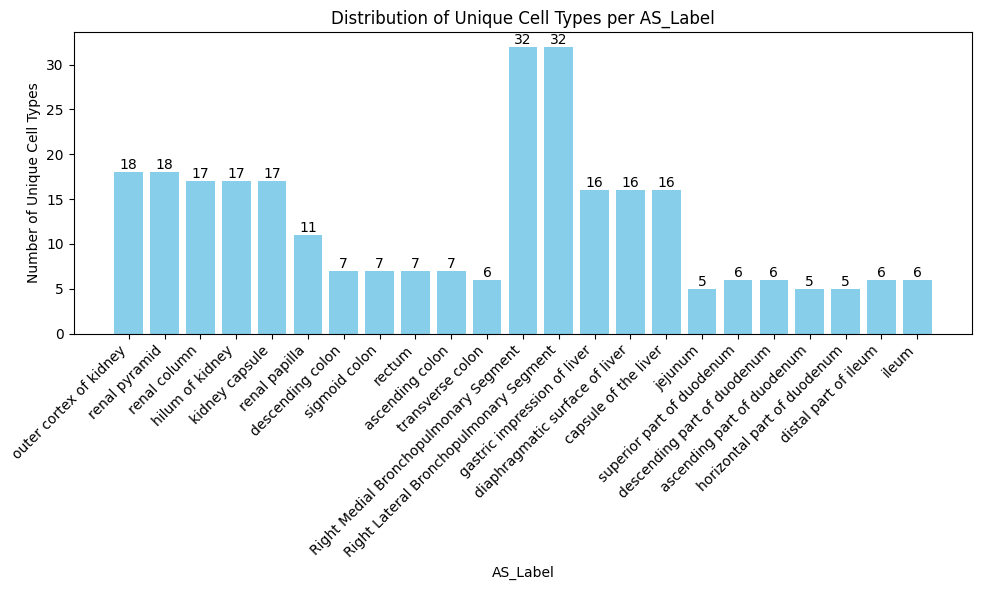

In [90]:
# Plotting the distribution with counts displayed on the bars
plt.figure(figsize=(10, 6))
bars = plt.bar(as_label_CTs_info['AS_Label'], as_label_CTs_info['Unique CTs Count'], color='skyblue')

# Adding the count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.xlabel('AS_Label')
plt.ylabel('Number of Unique Cell Types')
plt.title('Distribution of Unique Cell Types per AS_Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [91]:
filtered_enriched_v2_df['reference_organ'].unique()

array(['RightKidneyV1.1', 'RightKidney', 'LeftKidneyV1.1', 'LeftKidney',
       'Colon', 'Lung', 'Liver', 'SmallIntestine'], dtype=object)

In [92]:
difference_labels = set(CTs_with_datasets_df['cell_source_label'].unique()) - set(enriched_v1_df['as_label'])
print("Difference in cell_source_label:")
print(difference_labels)

Difference in cell_source_label:
{'caecum', 'right cardiac atrium', 'Left apical bronchopulmonary segment', 'peripheral zone of prostate', 'Lateral segmental bronchus', 'central zone of prostate', 'skin of body', 'hilum of spleen', 'diaphragmatic surface of spleen', 'left cardiac atrium', 'heart right ventricle', 'interventricular septum', 'Interlobar adipose tissue of right mammary gland', 'Posteromedial head of posterior papillary muscle of left ventricle'}


In [93]:
difference_source = set(CTs_with_datasets_df['cell_source_label'].unique()) - set(enriched_v2_df['as_label'])
print("Difference in cell_source_label:")
print(difference_source)

Difference in cell_source_label:
{'caecum', 'right cardiac atrium', 'Left apical bronchopulmonary segment', 'peripheral zone of prostate', 'Lateral segmental bronchus', 'central zone of prostate', 'skin of body', 'hilum of spleen', 'diaphragmatic surface of spleen', 'left cardiac atrium', 'heart right ventricle', 'interventricular septum', 'Interlobar adipose tissue of right mammary gland', 'Posteromedial head of posterior papillary muscle of left ventricle'}


In [94]:
# Extract cell_label and AS_label information from the JSON-LD data for source that are not found in enriched dataset
extracted_info = []
label_info = []
for label in difference_source:
    for entry in json_data_enriched:
        for entry in json_data_enriched["@graph"]:
            for sample in entry.get('samples', []):
                rui_location = sample.get('rui_location', {})
                all_collisions = rui_location.get('all_collisions', [])
                for collision in all_collisions:
                    collisions = collision.get('collisions', [])
                    for col in collisions:
                        as_label = col.get('as_label', 'unknown')
                        if as_label == label:
                            for section in sample.get('sections', []):
                                for dataset in section.get('datasets', []):
                                    summaries = dataset.get('summaries', [])                            
                                    for summary in summaries:
                                        for summ in summary['summary']:
                                            extracted_info.append({'as_label': as_label,
                                                            'cell_label': summ.get('cell_label', 'N/A')
                                                         })

# Convert the extracted information into a DataFrame for better visualization
df_extracted_info = pd.DataFrame(extracted_info)

df_extracted_info

,as_label,cell_label
0,skin of body,CD68 / Macrophage
1,skin of body,T-Killer
2,skin of body,T-reg
3,skin of body,T-helper
4,skin of body,CD68 / Macrophage
...,...,...
59,skin of body,T-helper
60,skin of body,CD68 / Macrophage
61,skin of body,T-Killer
62,skin of body,T-reg


In [95]:
df_extracted_info['as_label'].unique()

array(['skin of body'], dtype=object)

In [96]:
df_extracted_info['cell_label'].unique()

array(['CD68 / Macrophage', 'T-Killer', 'T-reg', 'T-helper'], dtype=object)

#### AS_Label to FTU mapping - Long table


| Cell Source Label                              | Corresponding FTU                  |
|------------------------------------------------|------------------------------------|
| renal pyramid                                  | Nephron, Inner Medullary Collecting Duct, Thick Ascending Limb, Ascending Thin Limb, Descending Thin Limb, Outer Medullary Collecting Duct    |
| outer cortex of kidney                         | Nephron, Renal Corpuscle, Cortical Collecting Duct, Outer Medullary Collecting Duct    |
| renal column                                   | Nephron, cortical collecting duct, Descending Thin Limb, Thick Ascending Limb, Ascending Thin Limb, Renal Corpuscle    |
| renal papilla                                  | Not applicable to listed FTUs    |
| left ureter                                    | Not applicable to listed FTUs      |
| hilum of kidney                                | Not applicable to listed FTUs      |
| kidney capsule                                 | Not applicable to listed FTUs      |
| descending colon                               | Crypt Of Lieberkuhn of large intestine |
| sigmoid colon                                  | Crypt Of Lieberkuhn of large intestine |
| rectum                                         | Crypt Of Lieberkuhn of large intestine |
| ascending colon                                | Crypt Of Lieberkuhn of large intestine |
| transverse colon                               | Crypt Of Lieberkuhn of large intestine |
| Right Medial Bronchopulmonary Segment          | Bronchial Submucosal Gland, Pulmonary Alveolus |
| Right Lateral Bronchopulmonary Segment         | Bronchial Submucosal Gland, Pulmonary Alveolus |
| gastric impression of liver                    | Liver Lobule                       |
| diaphragmatic surface of liver                 | Liver Lobule                       |
| capsule of the liver                           | Liver Lobule                       |
| jejunum                                        | Villus                             |
| superior part of duodenum                      | Villus                             |
| descending part of duodenum                    | Villus                             |
| ascending part of duodenum                     | Villus                             |
| horizontal part of duodenum                    | Villus                             |
| distal part of ileum                           | Villus                             |
| ileum                                          | Villus                             |


In [97]:
cell_source_to_ftu_mapping = {
    "renal pyramid": ["Nephron", "Inner Medullary Collecting Duct", "Thick Ascending Limb Of Loop Of Henle", "Loop Of Henle Ascending Limb Thin Segment", "Descending Limb of Loop of Henle", "Outer Medullary Collecting Duct"],
    "outer cortex of kidney": ["Nephron", "Renal Corpuscle", "Cortical Collecting Duct", "Outer Medullary Collecting Duct"],
    "renal column": ["Nephron", "Cortical Collecting Duct", "Descending Limb of Loop of Henle", "Thick Ascending Limb Of Loop Of Henle", "Loop Of Henle Ascending Limb Thin Segment", "Renal Corpuscle"],
    "renal papilla": None, # Not applicable to listed FTUs
    "hilum of kidney": None,  # Not applicable to listed FTUs
    "kidney capsule": None,  # Not applicable to listed FTUs
    "descending colon": ["Crypt Of Lieberkuhn of large intestine"],
    "sigmoid colon": ["Crypt Of Lieberkuhn of large intestine"],
    "rectum": ["Crypt Of Lieberkuhn of large intestine"],
    "ascending colon": ["Crypt Of Lieberkuhn of large intestine"],
    "transverse colon": ["Crypt Of Lieberkuhn of large intestine"],
    "Right Medial Bronchopulmonary Segment": ["Bronchial Submucosal Gland", "Alveolus of Lung"],
    "Right Lateral Bronchopulmonary Segment": ["Bronchial Submucosal Gland", "Alveolus of Lung"],
    "gastric impression of liver": ["Liver Lobule"],
    "diaphragmatic surface of liver": ["Liver Lobule"],
    "capsule of the liver": ["Liver Lobule"],
    "jejunum": ["Villus"],
    "superior part of duodenum": ["Villus"],
    "descending part of duodenum": ["Villus"],
    "ascending part of duodenum": ["Villus"],
    "horizontal part of duodenum": ["Villus"],
    "distal part of ileum": ["Villus"],
    "ileum": ["Villus"]
}

In [98]:
cell_source_with_no_ftu = [key for key, value in cell_source_to_ftu_mapping.items() if value is None]
cell_source_with_no_ftu

['renal papilla', 'hilum of kidney', 'kidney capsule']

In [99]:
filtered_v1_enriched_v2_df = filtered_enriched_v2_df[~filtered_enriched_v2_df['as_label'].isin(cell_source_with_no_ftu)]

In [100]:
print(filtered_v1_enriched_v2_df.shape, filtered_enriched_v2_df.shape, filtered_enriched_v1_df.shape, CTs_with_datasets_df.shape)

(41370, 18) (42910, 18) (42910, 13) (1302, 8)


In [101]:
villus = filtered_v1_enriched_v2_df[filtered_v1_enriched_v2_df['reference_organ'] == 'SmallIntestine']

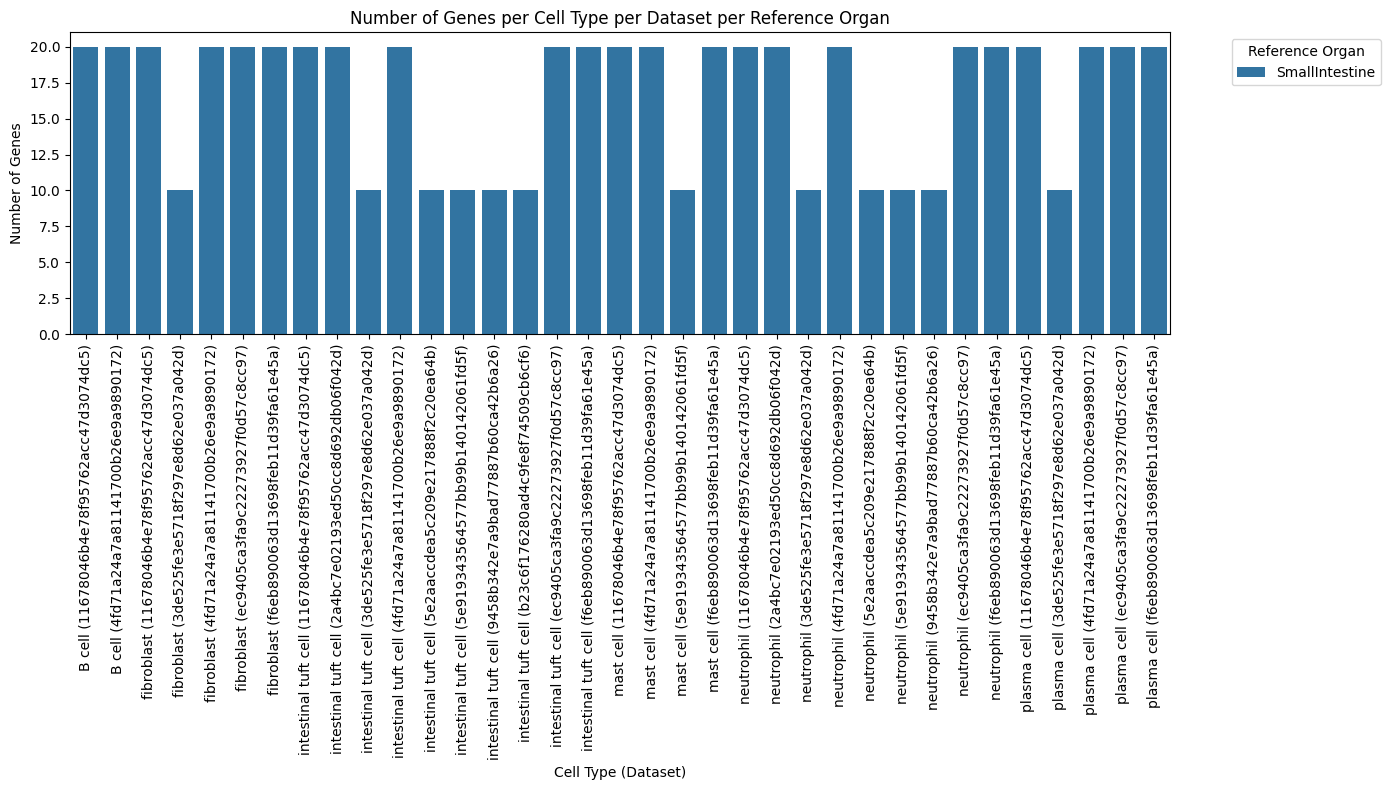

In [102]:
gene_counts = villus.groupby(['reference_organ', 'cell_label', 'dataset'])['gene_id'].count().reset_index()

# Renaming the column for clarity
gene_counts.rename(columns={'gene_id': 'gene_count'}, inplace=True)

# Simplify the x-axis labels by removing URLs and focusing on cell types and datasets
gene_counts['simple_label'] = gene_counts['cell_label'] + ' (' + gene_counts['dataset'].str.split('/').str[-1] + ')'

# Plotting with Seaborn to improve presentation
plt.figure(figsize=(14, 8))
sns.barplot(x='simple_label', y='gene_count', hue='reference_organ', data=gene_counts, dodge=False)

plt.xlabel('Cell Type (Dataset)')
plt.ylabel('Number of Genes')
plt.title('Number of Genes per Cell Type per Dataset per Reference Organ')
plt.xticks(rotation=90)
plt.legend(title='Reference Organ', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

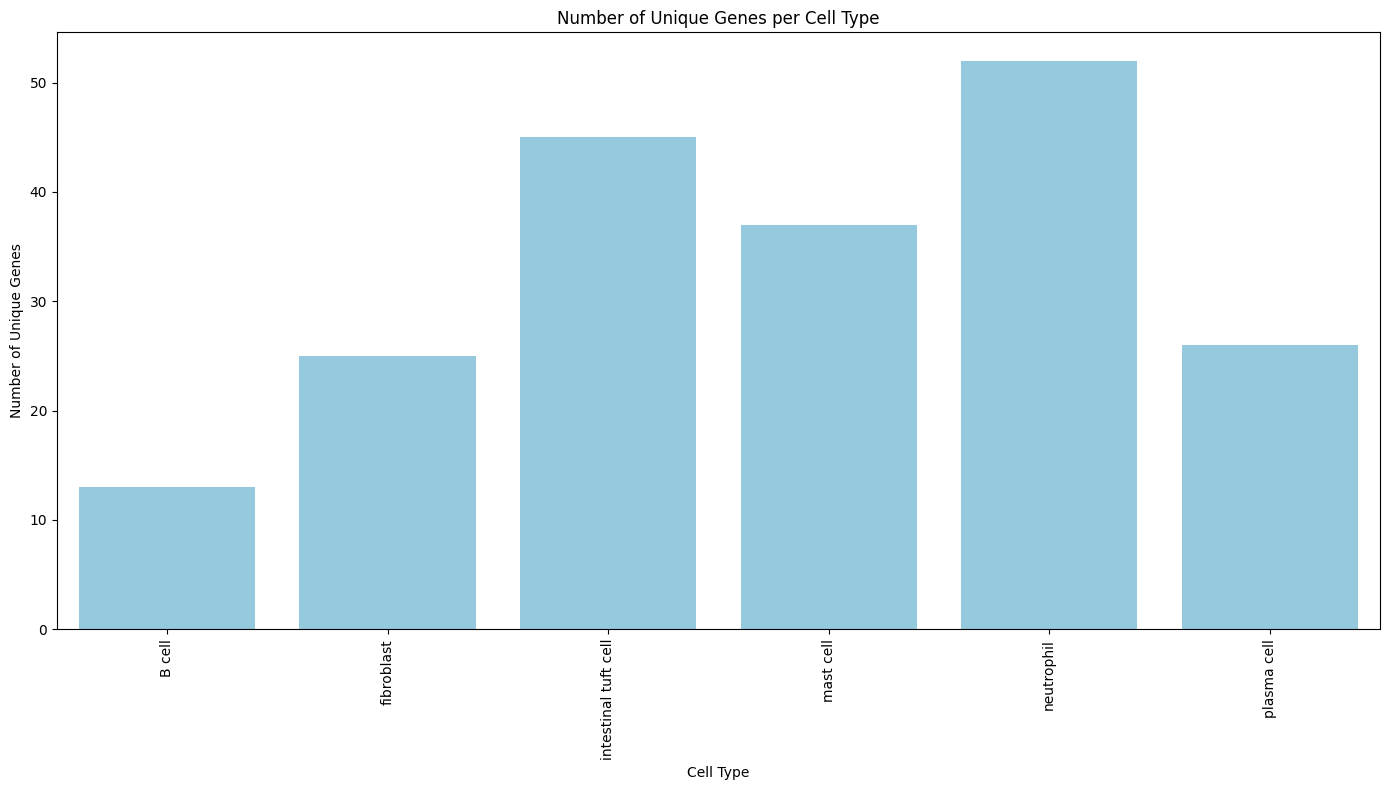

In [103]:
genes_per_cell_type = villus.groupby('cell_label')['gene_id'].nunique().reset_index()
genes_per_cell_type.rename(columns={'gene_id': 'unique_gene_count'}, inplace=True)

# Plotting the number of genes for each cell type
plt.figure(figsize=(14, 8))
sns.barplot(x='cell_label', y='unique_gene_count', data=genes_per_cell_type, color='skyblue')

plt.xlabel('Cell Type')
plt.ylabel('Number of Unique Genes')
plt.title('Number of Unique Genes per Cell Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

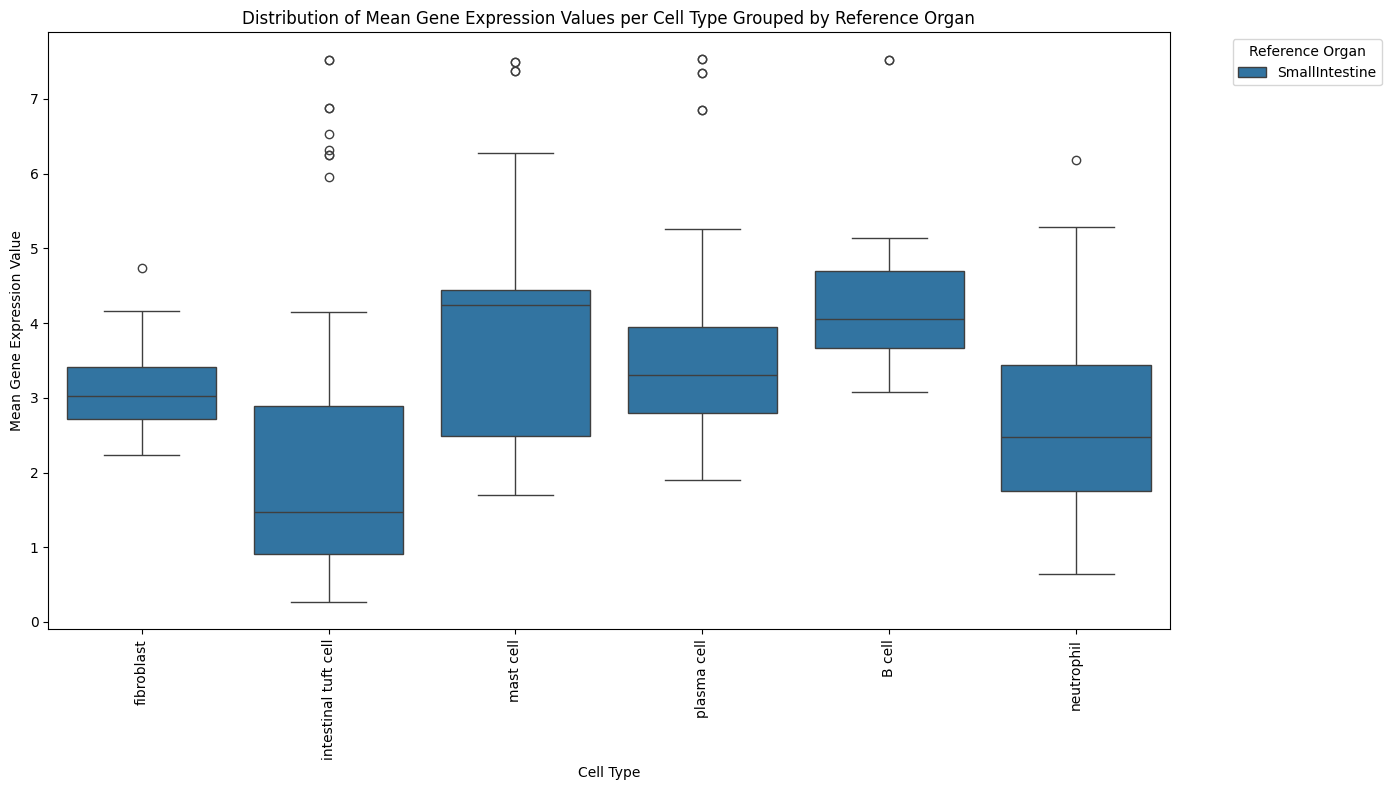

In [104]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='cell_label', y='mean_gene_expr_value', hue='reference_organ', data=villus)

plt.xlabel('Cell Type')
plt.ylabel('Mean Gene Expression Value')
plt.title('Distribution of Mean Gene Expression Values per Cell Type Grouped by Reference Organ')
plt.xticks(rotation=90)
plt.legend(title='Reference Organ', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

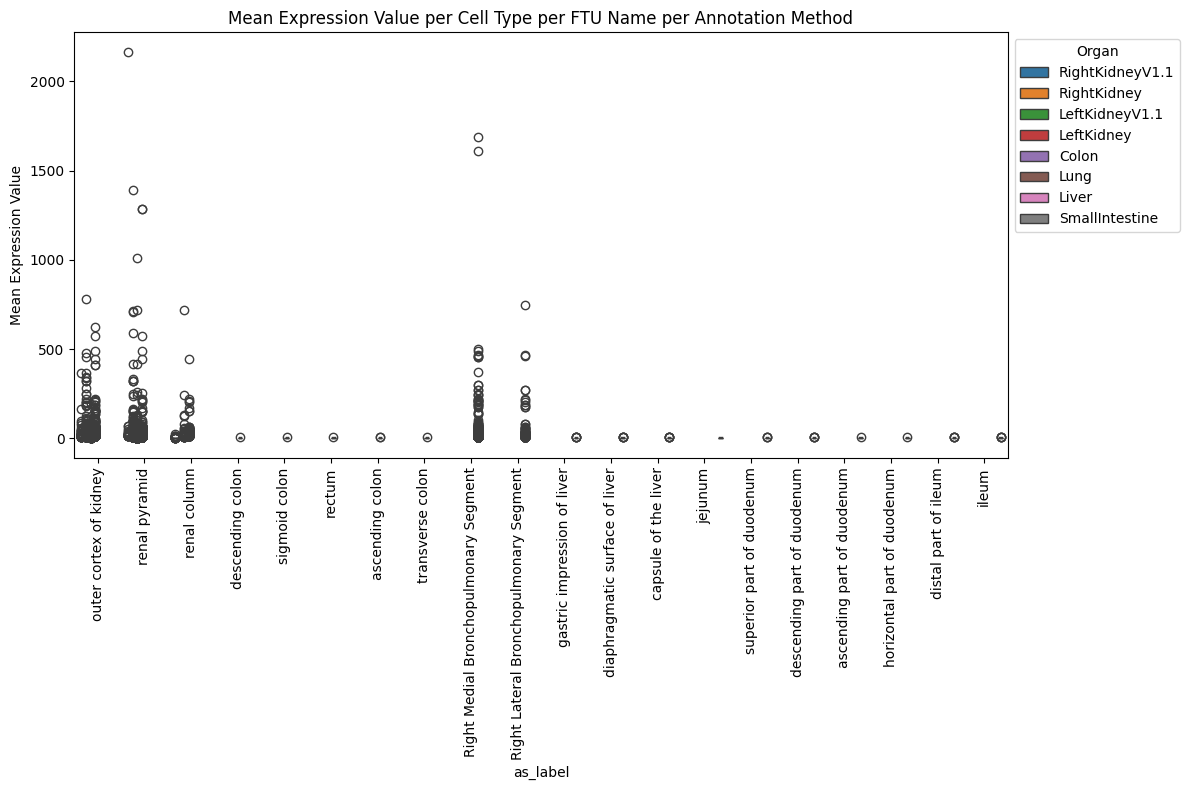

In [105]:
# Create a box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='as_label', y='mean_gene_expr_value', hue='reference_organ', data=filtered_v1_enriched_v2_df)

# Customize the plot
plt.title('Mean Expression Value per Cell Type per FTU Name per Annotation Method')
plt.xlabel('as_label')
plt.ylabel('Mean Expression Value')
plt.xticks(rotation=90)
plt.legend(title='Organ', bbox_to_anchor=(1, 1), loc='upper left')

# Save the plot to a file
#output_file_path = 'output/vasculature/mean-expression-box-plot-per-CT-per-FTU-per-AnnMethod.png'
plt.tight_layout()
#plt.savefig(output_file_path)
plt.show()

In [106]:
def map_ftu_corrected(row):
    as_label = row['as_label']
    cell_id = row['cell_id']
    organ_id = row['organ_id']  # Using 'reference_organ' instead of 'organ_id'

    ftu_options = cell_source_to_ftu_mapping.get(as_label, None)

    if ftu_options is None:
        return None

    # If only one FTU, return it
    if len(ftu_options) == 1:
        return ftu_options[0]

    # Otherwise, match based on cell_id and organ
    filtered_ftu = ftu_cell_count_filtered[(ftu_cell_count_filtered['CL_ID'] == cell_id) & (ftu_cell_count_filtered['Organ_ID'].str.lower() == organ_id.lower())]
    if not filtered_ftu.empty:
        matching_ftu = filtered_ftu[filtered_ftu['FTU Label in Uberon'].isin(ftu_options)]
        if not matching_ftu.empty:
            return matching_ftu['FTU Label in Uberon'].values[0]
    
    return None

# Applying the corrected mapping function to create the new "FTU" column
filtered_v1_enriched_v2_df['FTU'] = filtered_v1_enriched_v2_df.apply(map_ftu_corrected, axis=1)

C:\Users\Supriya\AppData\Local\Temp\ipykernel_18552\2480485541.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_v1_enriched_v2_df['FTU'] = filtered_v1_enriched_v2_df.apply(map_ftu_corrected, axis=1)


In [108]:
filtered_v1_enriched_v2_df['FTU'].unique()

array(['Cortical Collecting Duct', None, 'Nephron',
       'Outer Medullary Collecting Duct',
       'Inner Medullary Collecting Duct',
       'Loop Of Henle Ascending Limb Thin Segment', 'Renal Corpuscle',
       'Crypt Of Lieberkuhn of large intestine', 'Liver Lobule',
       'Bronchial Submucosal Gland', 'Alveolus of Lung', 'Villus'],
      dtype=object)

In [110]:
filtered_v1_enriched_v2_df.columns

Index(['organ_id', 'reference_organ', 'cell_id', 'cell_label',
       'annotation_method', 'as_label', 'sex', 'race', 'bmi', 'x_value',
       'y_value', 'z_value', 'link', 'dataset', 'gene_id', 'gene_label',
       'ensembl_id', 'mean_gene_expr_value', 'FTU'],
      dtype='object')

In [ ]:
filtered_v1_enriched_v2_df[filtered_v1_enriched_v2_df['FTU'] == ""]

In [ ]:
filtered_v1_enriched_v2_df['FTU'].unique()

In [111]:
# Rearrange the columns
desired_order = ['reference_organ', 'organ_id', 'as_label', 'sex', 'race', 'bmi', 'annotation_method', 'FTU',
                 'cell_id', 'cell_label', 'gene_id', 'gene_label', 'ensembl_id', 'mean_gene_expr_value', 'link',
                 'dataset', 'x_value','y_value', 'z_value']

# Check if all desired columns are in the dataframe
existing_columns = [col for col in desired_order if col in filtered_v1_enriched_v2_df.columns]

# Rearrange columns in the dataframe
filtered_v1_enriched_v2_df_rearranged = filtered_v1_enriched_v2_df[existing_columns]
filtered_v1_enriched_v2_df_rearranged.head()

,reference_organ,organ_id,as_label,sex,race,bmi,annotation_method,FTU,cell_id,cell_label,gene_id,gene_label,ensembl_id,mean_gene_expr_value,link,dataset,x_value,y_value,z_value
0,RightKidneyV1.1,http://purl.obolibrary.org/obo/UBERON_0002113,outer cortex of kidney,Female,Black or African American,53.06,azimuth,Cortical Collecting Duct,CL:1000715,Cortical Collecting Duct Intercalated Type A,HGNC:17438,CLNK,ENSG00000109684.15,18.478542,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,3,5,2
1,RightKidneyV1.1,http://purl.obolibrary.org/obo/UBERON_0002113,outer cortex of kidney,Female,Black or African American,53.06,azimuth,Cortical Collecting Duct,CL:1000715,Cortical Collecting Duct Intercalated Type A,HGNC:946,MAGI1,ENSG00000151276.23,43.448765,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,3,5,2
2,RightKidneyV1.1,http://purl.obolibrary.org/obo/UBERON_0002113,outer cortex of kidney,Female,Black or African American,53.06,azimuth,Cortical Collecting Duct,CL:1000715,Cortical Collecting Duct Intercalated Type A,HGNC:27295,FYB2,ENSG00000187889.13,6.035665,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,3,5,2
3,RightKidneyV1.1,http://purl.obolibrary.org/obo/UBERON_0002113,outer cortex of kidney,Female,Black or African American,53.06,azimuth,Cortical Collecting Duct,CL:1000715,Cortical Collecting Duct Intercalated Type A,HGNC:53807,MUC20-OT1,ENSG00000242086.8,16.502508,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,3,5,2
4,RightKidneyV1.1,http://purl.obolibrary.org/obo/UBERON_0002113,outer cortex of kidney,Female,Black or African American,53.06,azimuth,Cortical Collecting Duct,CL:1000715,Cortical Collecting Duct Intercalated Type A,HGNC:25308,TMEM117,ENSG00000139173.10,10.167935,https://portal.hubmapconsortium.org/browse/dat...,https://entity.api.hubmapconsortium.org/entiti...,3,5,2


In [112]:
# Save the combined dataframe to a CSV file
output_path = 'output/FTU-CTs-with-datasets-with-gene-information-wo-heart-UB.csv'
filtered_v1_enriched_v2_df_rearranged.to_csv(output_path, index=False)

In [ ]:
data = filtered_v1_enriched_v2_df

# 1. Distribution of FTUs across organs
plt.figure(figsize=(12, 6))
sns.countplot(y='FTU', data=data, order=data['FTU'].value_counts().index)
plt.title('Distribution of FTUs Across the Dataset')
plt.xlabel('Count')
plt.ylabel('FTU')
plt.show()

# 2. Distribution of gene expression values
plt.figure(figsize=(12, 6))
sns.boxplot(x='reference_organ', y='mean_gene_expr_value', data=data)
plt.title('Distribution of Gene Expression Values Across Reference Organs')
plt.xlabel('Reference Organ')
plt.ylabel('Mean Gene Expression Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Number of unique cell types per organ
unique_cell_types = data.groupby('reference_organ')['cell_label'].nunique().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='reference_organ', y='cell_label', data=unique_cell_types)
plt.title('Number of Unique Cell Types per Reference Organ')
plt.xlabel('Reference Organ')
plt.ylabel('Number of Unique Cell Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Scatter plot of gene expression vs. FTU
plt.figure(figsize=(12, 6))
sns.scatterplot(x='FTU', y='mean_gene_expr_value', data=data, hue='reference_organ')
plt.title('Gene Expression Values Across FTUs')
plt.xlabel('FTU')
plt.ylabel('Mean Gene Expression Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Number of genes per cell type per dataset per FTU
genes_per_cell_type_ftu = data.groupby(['FTU', 'cell_label', 'dataset'])['gene_label'].nunique().reset_index()
genes_per_cell_type_ftu.rename(columns={'gene_label': 'unique_gene_count'}, inplace=True)


# 5. Box Plot: Number of genes per cell type per dataset per FTU
plt.figure(figsize=(14, 8))
sns.boxplot(x='FTU', y='unique_gene_count', data=genes_per_cell_type_ftu)
plt.title('Number of Genes per Cell Type per Dataset per FTU')
plt.xlabel('FTU')
plt.ylabel('Number of Unique Genes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Number of datasets per FTU
datasets_per_ftu = data.groupby('FTU')['dataset'].nunique().reset_index()
datasets_per_ftu.rename(columns={'dataset': 'unique_dataset_count'}, inplace=True)

# 6. Violin Plot: Number of datasets per FTU
plt.figure(figsize=(14, 8))
sns.violinplot(x='FTU', y='unique_dataset_count', data=datasets_per_ftu)
plt.title('Distribution of Datasets per FTU')
plt.xlabel('FTU')
plt.ylabel('Number of Datasets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Number of genes per FTU per annotation method
genes_per_ftu_annotation = data.groupby(['FTU', 'annotation_method'])['gene_label'].nunique().reset_index()
genes_per_ftu_annotation.rename(columns={'gene_label': 'unique_gene_count'}, inplace=True)

# 7. Box Plot: Number of genes per FTU per annotation method
plt.figure(figsize=(14, 8))
sns.boxplot(x='FTU', y='unique_gene_count', hue='annotation_method', data=genes_per_ftu_annotation)
plt.title('Number of Genes per FTU per Annotation Method')
plt.xlabel('FTU')
plt.ylabel('Number of Unique Genes')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Annotation Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# 8. Violin Plot: Distribution of gene expression values per cell type
plt.figure(figsize=(14, 8))
sns.violinplot(x='cell_label', y='mean_gene_expr_value', data=data, inner='box', scale='width')
plt.title('Distribution of Gene Expression Values per Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Mean Gene Expression Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 9. Heatmap: Gene expression across different FTUs and cell types
plt.figure(figsize=(14, 8))
heatmap_data = data.pivot_table(index='FTU', columns='cell_label', values='mean_gene_expr_value', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='viridis', linewidths=0.5)
plt.title('Heatmap of Mean Gene Expression Across FTUs and Cell Types')
plt.xlabel('Cell Type')
plt.ylabel('FTU')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 10. Creating a pair plot to show relationships between gene expression and other features

# Selecting a subset of the data for the pair plot to avoid clutter
subset_data = data[['mean_gene_expr_value', 'cell_label', 'annotation_method', 'sex']]

# Encoding categorical variables as numbers for the pair plot
subset_data_encoded = pd.get_dummies(subset_data, drop_first=True)

# Creating the pair plot
sns.pairplot(subset_data_encoded, diag_kind='kde')
plt.suptitle('Pair Plot of Gene Expression Data', y=1.02)
plt.show()


In [ ]:
# Prepare data for Sankey diagram
# Get the top 10 most frequent FTU and Cell Label combinations
sankey_data = data.groupby(['FTU', 'cell_label']).size().reset_index(name='count')
sankey_data = sankey_data.sort_values('count', ascending=False).head(10)

# Create labels for the nodes
all_labels = list(sankey_data['FTU'].unique()) + list(sankey_data['cell_label'].unique())
label_map = {label: i for i, label in enumerate(all_labels)}

# Define the source, target, and values for the Sankey diagram
sources = sankey_data['FTU'].map(label_map)
targets = sankey_data['cell_label'].map(label_map)
values = sankey_data['count']

# Create the Sankey diagram
sankey_fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_labels
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
))

sankey_fig.update_layout(title_text="Sankey Diagram: FTU to Cell Type", font_size=10)
sankey_fig.show()

In [ ]:
# Prepare the data
sankey_data = data.groupby(['annotation_method', 'FTU', 'cell_label', 'gene_label']).size().reset_index(name='count')

# Create labels for the nodes
all_labels = list(sankey_data['annotation_method'].unique()) + \
             list(sankey_data['FTU'].unique()) + \
             list(sankey_data['cell_label'].unique()) + \
             list(sankey_data['gene_label'].unique())

label_map = {label: i for i, label in enumerate(all_labels)}

# Define the source, target, and values for the Sankey diagram
sources = sankey_data['annotation_method'].map(label_map).tolist() + \
          sankey_data['FTU'].map(label_map).tolist() + \
          sankey_data['cell_label'].map(label_map).tolist()

targets = sankey_data['FTU'].map(label_map).tolist() + \
          sankey_data['cell_label'].map(label_map).tolist() + \
          sankey_data['gene_label'].map(label_map).tolist()

values = sankey_data['count'].tolist() * 3  # repeating the counts for each layer

# Create the Sankey diagram
sankey_fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_labels
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
))

sankey_fig.update_layout(title_text="Detailed Sankey Diagram: Annotation Method to FTU, Cell Type, Gene Label", font_size=10)
sankey_fig.write_image("sankey_diagram_high_res.png", width=1920, height=1080)

### Organ and CTann level information as per CTann crosswalk files 

In [ ]:
# Get the unique organ levels for each file
azimuth_organs = azimuth['Organ_Level'].unique().tolist()
celltypist_organs = celltypist['Organ_Level'].unique().tolist()
popv_organs = popv['Organ_Level'].unique().tolist()

print("Azimuth Organs:", azimuth_organs)
print()
print("Celltypist Organs:", celltypist_organs)
print()
print("Popv Organs:", popv_organs)

In [ ]:
# Rename the column in final_output_df
CTs_with_datasets_df.rename(columns={'cell_id': 'CL_ID'}, inplace=True)

# Merge with azimuth_df
final_output_azimuth = CTs_with_datasets_df[CTs_with_datasets_df['annotation_method'] == 'azimuth'].merge(
    azimuth[['CL_ID', 'Organ_Level']], on='CL_ID', how='left')

# Merge with celltypist_df
final_output_celltypist = CTs_with_datasets_df[CTs_with_datasets_df['annotation_method'] == 'celltypist'].merge(
    celltypist[['CL_ID', 'Organ_Level']], on='CL_ID', how='left')

# Merge with popv_df
final_output_popv = CTs_with_datasets_df[CTs_with_datasets_df['annotation_method'] == 'popv'].merge(
    popv[['CL_ID', 'Organ_Level']], on='CL_ID', how='left')

# Combine all the dataframes
final_output_combined = pd.concat([final_output_azimuth, final_output_celltypist, final_output_popv], ignore_index=True)

# Define the organ levels for each annotation method
azimuth_organs = ['Kidney_L3', 'Lung_v2_finest_level', 'Liver_L2', 'Liver_L1', 'Kidney_L1',  'Kidney_L2', 
                  'Lung_v2_L1', 'Lung_v2_L2', 'Lung_v2_L3', 'Lung_v2_L4', 'Lung_v2_L5', 'Pancreas_L1']
celltypist_organs = ['intestine_L1', 'kidney_L1', 'liver_L1', 'lung_L1', 'pancreas_L1', 'spleen_L1', 
                     'Adult_Human_Skin_pkl', 'Healthy_Human_Liver_pkl', 'Adult_Human_PancreaticIslet_pkl', 
                     'Human_Lung_Atlas_pkl']
popv_organs = ['large intestine', 'liver', 'lung', 'male reproductive system', 'pancreas', 'prostate gland', 
               'respiratory system', 'skin', 'small intestine', 'spleen', 'thymus']

# Filter the combined dataframe for each annotation method and their corresponding organ levels
filtered_azimuth = final_output_combined[(final_output_combined['annotation_method'] == 'azimuth') & 
                                         (final_output_combined['Organ_Level'].isin(azimuth_organs))]

filtered_celltypist = final_output_combined[(final_output_combined['annotation_method'] == 'celltypist') & 
                                            (final_output_combined['Organ_Level'].isin(celltypist_organs))]

filtered_popv = final_output_combined[(final_output_combined['annotation_method'] == 'popv') & 
                                      (final_output_combined['Organ_Level'].isin(popv_organs))]

# Combine the filtered dataframes
final_filtered_combined = pd.concat([filtered_azimuth, filtered_celltypist, filtered_popv], ignore_index=True)

final_filtered_combined.head()

In [ ]:
# Save the combined dataframe to a CSV file
output_path = 'output/CTs-with-datasets-with-organ.csv'
final_filtered_combined.to_csv(output_path, index=False)

###  Extract gene information for Cell types in vasculature

In [ ]:
# Provided CT Labels and CT IDs
ct_labels_ids = {
    "glomerular capillary endothelial cell": "CL:1001005",
    "efferent arteriole endothelial cell": "CL:1001099",
    "afferent arteriole endothelial cell": "CL:1001096",
    "peritubular capillary endothelial cell": "CL:1001033",
    "vasa recta ascending limb cell": "CL:1001131",
    "vasa recta descending limb cell": "CL:1001285",
    "alveolar capillary type 1 endothelial cell": "CL:4028002",
    "capillary endothelial cell": "CL:0002144",
    "blood vessel smooth muscle cell": "CL:0019018",
    "endothelial cell of artery": "CL:1000413",
    "vein endothelial cell": "CL:0002543",
    "endothelial cell of hepatic sinusoid": "CL:1000398",
    "prostate gland microvascular endothelial cell": "CL:2000059",
    "blood vessel endothelial cell": "CL:0000071",
    "splenic endothelial cell": "CL:2000053"
}

In [ ]:
# Identifying the structure within the "@graph" key to process accordingly
graph_data = json_data_enriched["@graph"]

In [ ]:
# Grouping ensembl_ids by cell_id and adding cell_label
grouped_matches = {}
for item in graph_data:
    samples = item.get("samples", [])
    for sample in samples:
        sections = sample.get("sections", [])
        for section in sections:
            datasets = section.get("datasets", [])
            for dataset in datasets:
                summaries = dataset.get("summaries", [])
                for summary in summaries:
                    sum_details = summary.get("summary", [])
                    for sum_detail in sum_details:
                        cell_id = sum_detail.get("cell_id")
                        gene_expr_list = sum_detail.get("gene_expr", [])
                        if cell_id in ct_labels_ids.values():
                            if isinstance(gene_expr_list, list):
                                for gene_expr in gene_expr_list:
                                    if isinstance(gene_expr, dict):
                                        ensembl_id = gene_expr.get("ensembl_id")
                                        if cell_id not in grouped_matches:
                                            grouped_matches[cell_id] = {"cell_label": "", "ensembl_ids": []}
                                        grouped_matches[cell_id]["cell_label"] = [label for label, id in ct_labels_ids.items() if id == cell_id][0]
                                        grouped_matches[cell_id]["ensembl_ids"].append(ensembl_id)

# Preparing the final dataframe
final_matches = []
for cell_id, details in grouped_matches.items():
    final_matches.append({
        "cell_id": cell_id,
        "cell_label": details["cell_label"],
        "ensembl_ids": ", ".join(details["ensembl_ids"])
    })

final_matches_df = pd.DataFrame(final_matches)
final_matches_df.head()

In [ ]:
# Displaying the final dataframe
final_matches_df.to_csv('output/vasculature/Biomarker_for_Vasculature_CTs.csv')

In [ ]:
final_matches_df['cell_id'].unique()

In [ ]:
# Grouping ensembl_ids by cell_id and organ_id, adding cell_label and mean_gene_expr_value
grouped_matches = {}
for item in graph_data:
    samples = item.get("samples", [])
    for sample in samples:
        sections = sample.get("sections", [])
        for section in sections:
            datasets = section.get("datasets", [])
            for dataset in datasets:
                summaries = dataset.get("summaries", [])               
                for summary in summaries:
                    annotation_method = summary.get("annotation_method", "Unknown")
                    sum_details = summary.get("summary", [])
                    for sum_detail in sum_details:
                        cell_id = sum_detail.get("cell_id")
                        gene_expr_list = sum_detail.get("gene_expr", [])
                        organ_id = dataset.get("organ_id", "Unknown")
                        if cell_id in ct_labels_ids.values():
                            if isinstance(gene_expr_list, list) and gene_expr_list:
                                for gene_expr in gene_expr_list:
                                    if isinstance(gene_expr, dict):
                                        ensembl_id = gene_expr.get("ensembl_id")
                                        mean_expr_value = gene_expr.get("mean_gene_expr_value")
                                        key = (cell_id, organ_id, annotation_method)
                                        if key not in grouped_matches:
                                            grouped_matches[key] = {"cell_label": "", "ensembl_ids": [], "mean_expr_values": []}
                                        grouped_matches[key]["cell_label"] = [label for label, id in ct_labels_ids.items() if id == cell_id][0]
                                        grouped_matches[key]["ensembl_ids"].append(ensembl_id)
                                        grouped_matches[key]["mean_expr_values"].append(mean_expr_value)
                            else:
                                # Handle entries with empty gene_expr lists
                                key = (cell_id, organ_id, annotation_method)
                                if key not in grouped_matches:
                                    grouped_matches[key] = {"cell_label": "", "ensembl_ids": [], "mean_expr_values": []}
                                grouped_matches[key]["cell_label"] = [label for label, id in ct_labels_ids.items() if id == cell_id][0]

# Preparing the final dataframe
final_matches = []
for (cell_id, organ_id, annotation_method), details in grouped_matches.items():
    final_matches.append({
        "cell_id": cell_id,
        "cell_label": details["cell_label"],
        "organ_id": organ_id,
        "annotation_method": annotation_method,
        "ensembl_ids": ", ".join(details["ensembl_ids"]),
        "mean_expr_values": ", ".join(map(str, details["mean_expr_values"]))
    })

final_matches_df = pd.DataFrame(final_matches)

# Expanding the dataframe to have each row for each ensembl_id
expanded_matches = []
for _, row in final_matches_df.iterrows():
    cell_id = row["cell_id"]
    cell_label = row["cell_label"]
    organ_id = row["organ_id"]
    annotation_method = row["annotation_method"]
    ensembl_ids = row["ensembl_ids"].split(", ")
    mean_expr_values = row["mean_expr_values"].split(", ")
    
    for ensembl_id, mean_expr_value in zip(ensembl_ids, mean_expr_values):
        try:
            mean_expr_value_float = float(mean_expr_value)
        except ValueError:
            mean_expr_value_float = None  # Handle non-numeric values
        expanded_matches.append({
            "cell_id": cell_id,
            "cell_label": cell_label,
            "organ_id": organ_id,
            "annotation_method": annotation_method,
            "ensembl_id": ensembl_id,
            "mean_expr_value": mean_expr_value_float
        })

expanded_matches_df = pd.DataFrame(expanded_matches)

# Displaying the expanded dataframe
expanded_matches_df.head()  # Displaying only the first few rows

In [ ]:
# Extract unique organ IDs from the expanded dataframe
unique_organ_ids = expanded_matches_df["organ_id"].unique()

unique_organ_ids_list = unique_organ_ids.tolist()
unique_organ_ids_list

In [ ]:
organ_id_to_organ_name = {
         'http://purl.obolibrary.org/obo/UBERON_0002113' : 'Kidney',
         'http://purl.obolibrary.org/obo/UBERON_0000948' : 'heart',
         'http://purl.obolibrary.org/obo/UBERON_0001255': 'urinary bladder',
         'http://purl.obolibrary.org/obo/UBERON_0002048' : 'lung',
         'http://purl.obolibrary.org/obo/UBERON_0002107' : 'liver'
        }

In [ ]:
# Adding a new column to the dataframe
expanded_matches_df['organ_name'] = expanded_matches_df['organ_id'].map(organ_id_to_organ_name)

# Display the first few rows of the updated dataframe
expanded_matches_df.head() 

In [ ]:
expanded_matches_df['organ_name'].unique()

In [ ]:
# Select and clean up relevant columns from FTU dataframe
ftu_cleaned_df = ftu_cell_count[['Organ', 'CL_Label_FTU', 'FTU Label in Uberon']].dropna().drop_duplicates()

# Ensure unique mapping by dropping duplicates based on 'CT Label in CL'
ftu_unique_df = ftu_cleaned_df.drop_duplicates(subset=['CL_Label_FTU'])

# Perform the match and add the new column for FTU name
expanded_matches_df['FTU_name'] = expanded_matches_df['cell_label'].map(
    ftu_unique_df.set_index('CL_Label_FTU')['FTU Label in Uberon']
)

# Adding the organ name from FTU data
expanded_matches_df['Organ_name_FTU'] = expanded_matches_df['cell_label'].map(
    ftu_unique_df.set_index('CL_Label_FTU')['Organ']
)

# Rearrange columns as per the requirement
expanded_matches_df = expanded_matches_df[[
    'organ_name', 'Organ_name_FTU','organ_id', 'annotation_method', 'FTU_name', 'cell_id', 'cell_label', 'ensembl_id', 'mean_expr_value'
]]

# Rename columns for consistency
expanded_matches_df.rename(columns={
    'organ_name': 'organ_name',
    'Organ_name_FTU': 'organ_name_in_FTU'
}, inplace=True)

# Display the first few rows of the updated dataframe
expanded_matches_df.head()

In [ ]:
# Drop rows where organ_name is 'heart' or 'urinary bladder'
matches_df_filtered = expanded_matches_df[~expanded_matches_df['organ_name'].isin(['heart', 'urinary bladder'])]

In [ ]:
matches_df_filtered.to_csv('output/vasculature/gene_information-for-vasculature-CTs-1.csv', index=False)

In [ ]:
matches_df_filtered['FTU_name'].unique()

#### Generate box plot images for unique cell label

In [ ]:
# Create individual box plots for each cell_label
unique_cell_labels = matches_df_filtered['cell_label'].unique()

for cell_label in unique_cell_labels:
    cell_label_data = matches_df_filtered[matches_df_filtered['cell_label'] == cell_label]
    
    if len(cell_label_data) > 1:  # Ensure there is enough data to plot
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=cell_label_data, y='mean_expr_value', color='skyblue')
        
        # Customize the box plot
        plt.xticks([])
        plt.title(f'Box Plot of Mean Expression Values for {cell_label}')
        plt.xlabel('Cell Label')
        plt.ylabel('Mean Expression Value')
        
        # Adding additional visual elements
        plt.axhline(y=cell_label_data['mean_expr_value'].median(), color='red', linestyle='-', label='Median')
        plt.legend()

        # Save each plot as an image file
        individual_box_plot_file_path = f'output/vasculature/figures/box_plot_mean_expr_value_{cell_label.replace(" ", "_")}.png'
        plt.tight_layout()
        plt.savefig(individual_box_plot_file_path)
        plt.close()

#### Generate box plot images for unique cell label per annotation method

In [ ]:
unique_annotation_methods = matches_df_filtered['annotation_method'].explode().unique()
unique_annotation_methods

In [ ]:
unique_annotation_methods = matches_df_filtered['annotation_method'].explode().unique()

for cell_label in unique_cell_labels:
    for annotation_method in unique_annotation_methods:
        cell_label_data = matches_df_filtered[
            (matches_df_filtered['cell_label'] == cell_label) &
            (matches_df_filtered['annotation_method'] == annotation_method)
        ]
        
        if len(cell_label_data) > 1:  # Ensure there is enough data to plot
            plt.figure(figsize=(8, 6))
            sns.boxplot(data=cell_label_data, y='mean_expr_value', color='skyblue')
            
            # Customize the box plot
            plt.xticks([])
            plt.title(f'Box Plot of Mean Expression Values for {cell_label} ({annotation_method})')
            plt.xlabel('Cell Label')
            plt.ylabel('Mean Expression Value')
            
            # Adding additional visual elements
            plt.axhline(y=cell_label_data['mean_expr_value'].median(), color='red', linestyle='-', label='Median')
            plt.legend()

            # Save each plot as an image file
            individual_box_plot_file_path = f'output/vasculature/figures/box_plot_mean_expr_value_{cell_label.replace(" ", "_")}_{annotation_method.replace(" ", "_")}.png'
            plt.tight_layout()
            plt.savefig(individual_box_plot_file_path)
            plt.close()

# List of generated plot file paths
plot_file_paths = [f'output/vasculature/figures/box_plot_mean_expr_value_{cell_label.replace(" ", "_")}_{annotation_method.replace(" ", "_")}.png'
                   for cell_label in unique_cell_labels
                   for annotation_method in unique_annotation_methods
                   if len(matches_df_filtered[(matches_df_filtered['cell_label'] == cell_label) & (matches_df_filtered['annotation_method'] == annotation_method)]) > 1]

plot_file_paths

In [ ]:
# Create a box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='FTU_name', y='mean_expr_value', hue='annotation_method', data=matches_df_filtered)

# Customize the plot
plt.title('Mean Expression Value per Cell Type per FTU Name per Annotation Method')
plt.xlabel('FTU Name')
plt.ylabel('Mean Expression Value')
plt.xticks(rotation=45)
plt.legend(title='Annotation Method', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot to a file
output_file_path = 'output/vasculature/mean-expression-box-plot-per-CT-per-FTU-per-AnnMethod.png'
plt.tight_layout()
plt.savefig(output_file_path)
plt.show()

In [ ]:
# Create a box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='FTU_name', y='mean_expr_value', hue='cell_label', data=matches_df_filtered)

# Customize the plot
plt.title('Mean Expression Value per Cell Type per FTU Name')
plt.xlabel('FTU Name')
plt.ylabel('Mean Expression Value')
plt.xticks(rotation=45)
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot to a file
output_file_path = 'output/vasculature/mean_expression_box_plot_per_cell_type.png'
plt.tight_layout()
plt.savefig(output_file_path)
plt.show()

### Understand the JSON files

In [ ]:
# Function to extract as_label, link, and cell_id from the JSON data
def extract_all_entries(json_data):
    result = []
    for entry in json_data['@graph']:
        for sample in entry.get('samples', []):
            rui_location = sample.get('rui_location', {})
            all_collisions = rui_location.get('all_collisions', [])
            for collision in all_collisions:
                collisions = collision.get('collisions', [])
                for col in collisions:
                    as_label = col.get('as_label', 'unknown')
                    for section in sample.get('sections', []):
                        for dataset in section.get('datasets', []):
                            link = dataset.get('link', 'unknown')
                            for summary in dataset.get('summaries', []):
                                for summary_item in summary.get('summary', []):
                                    cell_id = summary_item.get('cell_id', 'unknown')
                                    cell_label = summary_item.get('cell_label', 'unknown')
                                    new_row = {
                                        'as_label': as_label,
                                        'link': link,
                                        'cell_label': cell_label,
                                        'cell_id': cell_id
                                    }
                                    result.append(new_row)
    return result

# Extract all entries
extracted_data_enriched = extract_all_entries(json_data_enriched)

# Convert extracted data to a DataFrame
extracted_df_enriched = pd.DataFrame(extracted_data_enriched)

# Display the DataFrame's head
print(extracted_df_enriched.head())

In [ ]:
extracted_df_enriched.to_csv('output/sanity_check/Dataset-source-cell-enriched.csv', index=False)

In [ ]:
# Extract cell IDs from the summary section
def extract_cell_ids(data):
    cell_ids = []
    for item in data['@graph']:
        samples = item.get("samples", [])
        for sample in samples:
            sections = sample.get("sections", [])
            for section in sections:
                datasets = section.get("datasets", [])
                for dataset in datasets:
                    summaries = dataset.get("summaries", [])               
                    for summary in summaries:
                        sum_details = summary.get("summary", [])
                        for sum_detail in sum_details:
                            cell_id = sum_detail.get("cell_id")
                            cell_ids.append(cell_id)
    return cell_ids

cell_ids = extract_cell_ids(json_data_enriched)
print(f"Cell IDs from the file: {len(cell_ids)}")

In [ ]:
def extract_cell_ids_summaries(data):
    cell_ids = []
    for item in data['@graph']:
        summaries = item.get('summary', [])
        for summary in summaries:
            for detail in summary:
                if 'cell_id' in detail:
                    cell_ids.append(summary['cell_id'])
    return cell_ids

cell_ids_summaries = extract_cell_ids_summaries(json_data_summary)
print(f"Cell IDs from the file: {len(cell_ids_summaries)}")

In [ ]:
# Function to extract aggregated_summaries, cell_source_label, cell_label, and cell_id from the JSON data
graph_data = json_data_summary.get('@graph', [])

extracted_data_summary = []

for item in graph_data:
    if 'summary' in item:
        for summary in item['summary']:
            for summary in summaries:
                if 'cell_id' in summary and 'cell_label' in summary:
                    for aggregated_summary in aggregated_summaries:
                        extracted_entry = {
                    'cell_source_label': cell_source_label,
                    'aggregated_summary': aggregated_summary,
                    'cell_label': summary.get('cell_label'),
                    'cell_id': summary.get('cell_id')
                        }
                        extracted_data_summary.append(extracted_entry)

# Convert extracted data to a DataFrame
extracted_df_summary = pd.DataFrame(extracted_data_summary)

# Display the DataFrame's head
print(extracted_df_summary.head())

In [ ]:
extracted_df_summary.to_csv('output/sanity_check/Dataset-source-cell-summary.csv', index=False)

In [ ]:
result_df['dataset'].nunique()

In [ ]:
latest_filtered_cts_df = filtered_v1_enriched_v2_df_rearranged.copy()

# Extract the relevant part of the reference_organ (after '#VHF')
latest_filtered_cts_df['reference_organ_clean'] = latest_filtered_cts_df['reference_organ'].apply(lambda x: x.split('#')[-1])

# Remove 'VHF' or 'VHM' from the 'reference_organ_clean' field
latest_filtered_cts_df['reference_organ_clean'] = latest_filtered_cts_df['reference_organ_clean'].str.replace('VHF', '').str.replace('VHM', '')

# Create a new column combining reference_organ_clean and as_label
latest_filtered_cts_df['y_label_clean'] = latest_filtered_cts_df['reference_organ_clean'] + "_" + latest_filtered_cts_df['as_label']

# Count the number of unique datasets per reference_organ + as_label combination for each annotation_method
latest_dataset_counts = latest_filtered_cts_df.groupby(['annotation_method', 'y_label_clean', 'sex']).dataset.nunique().reset_index()
latest_dataset_counts = latest_dataset_counts.rename(columns={'dataset': 'unique_dataset_count'})

# Debug: Check the unique dataset counts
print(latest_dataset_counts.head())

# Combine the male and female dataframes and create a new column for sex
latest_dataset_counts_combined = latest_dataset_counts.copy()
latest_dataset_counts_combined['sex_label'] = latest_dataset_counts_combined['sex']

# Define a custom color palette for better visualization
custom_palette = sns.color_palette("tab10")

# Set figure size and fonts for better readability
plt.figure(figsize=(14, 10))

g_combined = sns.catplot(
    data=latest_dataset_counts_combined,
    x="unique_dataset_count", y="y_label_clean", hue="sex_label",
    col="annotation_method", kind="bar",
    height=8, aspect=1.5, col_wrap=1,
    palette=custom_palette
)

g_combined.set_axis_labels("Number of Unique Datasets", "")
g_combined.set_titles("{col_name}")
g_combined.fig.suptitle("Number of Unique Datasets by Annotation Method and Sex", y=1.02)
g_combined.set_xticklabels(fontsize=10)
g_combined.set_yticklabels(fontsize=10)
g_combined.set_xlabels("Number of Unique Datasets", fontsize=12)
g_combined.set_ylabels("", fontsize=12)

# Annotate the bars with the number of unique datasets, handling NaN values
for ax in g_combined.axes.flatten():
    for c in ax.containers:
        labels = [f'{int(v.get_width()):.0f}' if not pd.isna(v.get_width()) else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=10)

# Save the plot as a high-resolution image
g_combined.savefig("output/figures/Datasets-AS-Annotation-Sex.png", dpi=300)

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

sns.violinplot(
    data=latest_dataset_counts_combined,
    x="unique_dataset_count", y="annotation_method", hue="sex_label",
    split=True, inner="quart", palette=custom_palette
)

plt.title("Distribution of Unique Datasets by Annotation Method and Sex")
plt.xlabel("Count")
plt.ylabel("Annotation Method")
plt.xlim(0, 50)
plt.legend(title="Sex")
plt.show()

In [ ]:
unique_sexes_popv = filtered_v1_enriched_v2_df_rearranged[filtered_v1_enriched_v2_df_rearranged['annotation_method'] == 'popv']['sex'].unique()
print(unique_sexes_popv)

In [ ]:
unique_sexes_azimuth = filtered_v1_enriched_v2_df_rearranged[filtered_v1_enriched_v2_df_rearranged['annotation_method'] == 'azimuth']['sex'].unique()
print(unique_sexes_azimuth)

In [ ]:
unique_sexes_celltypist = filtered_v1_enriched_v2_df_rearranged[filtered_v1_enriched_v2_df_rearranged['annotation_method'] == 'celltypist']['sex'].unique()
print(unique_sexes_celltypist)